This notebook involves implemntation of various codes on VHI dataset of Karnataka including the ensemble models

In [ ]:
import numpy as np
#from google.colab.patches import cv2_imshow
from PIL import Image
import cv2
import scipy.misc
import matplotlib
#import xgboost as XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, ConvLSTM2D, Flatten, Dropout, MaxPooling2D,MaxPooling3D, TimeDistributed, Conv2D, LSTM, SimpleRNN, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import io
import matplotlib.pyplot as plt
import imageio
from sklearn.metrics import r2_score
# from IPython.display import Image, display
# from ipywidgets import widgets, Layout, HBox
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import UpSampling3D
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import History
from tensorflow import keras
import tensorflow_addons as tfa

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Data Loading

In [ ]:
#data preprocessing

# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = np.load(filename)
	# unpack arrays
	X1, X2 = data['x'], data['y']
	# scale from [0,255] to [-1,1]
	# X1 = (X1 - 127.5) / 127.5
	# X2 = (X2 - 127.5) / 127.5
	return [X1, X2]



In [ ]:
dataset = load_real_samples("F:\Jyoti Shukla -MS\karnataka dataset\paired_padded_arrays_train_total_AVHRR_data.npz")
dataset_test = load_real_samples('F:\Jyoti Shukla -MS\karnataka dataset\paired_padded_arrays_test_total_AVHRR_data.npz')
train_dataset, train_labels = dataset[0],dataset[1]
test_dataset, test_labels = dataset_test[0], dataset_test[1]
# Inspect the dataset.
print("Training Dataset Shapes: " + str(train_dataset.shape) + ", " + str(train_labels.shape))
print("Validation Dataset Shapes: " + str(test_dataset.shape) + ", " + str(test_labels.shape))

Training Dataset Shapes: (2069, 192, 128, 1), (2069, 192, 128, 1)
Validation Dataset Shapes: (52, 192, 128, 1), (52, 192, 128, 1)


In [ ]:
#@title
dataset = load_real_samples("F:\Jyoti Shukla -MS\karnataka dataset\paired_arrays_train_AVHRR_data.npz")
dataset_test = load_real_samples('F:\Jyoti Shukla -MS\karnataka dataset\paired_arrays_test_AVHRR_data.npz')
train_dataset, train_labels = dataset[0],dataset[1]
test_dataset, test_labels = dataset_test[0], dataset_test[1]
# Inspect the dataset.
print("Training Dataset Shapes: " + str(train_dataset.shape) + ", " + str(train_labels.shape))
print("Validation Dataset Shapes: " + str(test_dataset.shape) + ", " + str(test_labels.shape))

Training Dataset Shapes: (1899, 190, 124, 1), (1899, 190, 124, 1)
Validation Dataset Shapes: (60, 190, 124, 1), (60, 190, 124, 1)


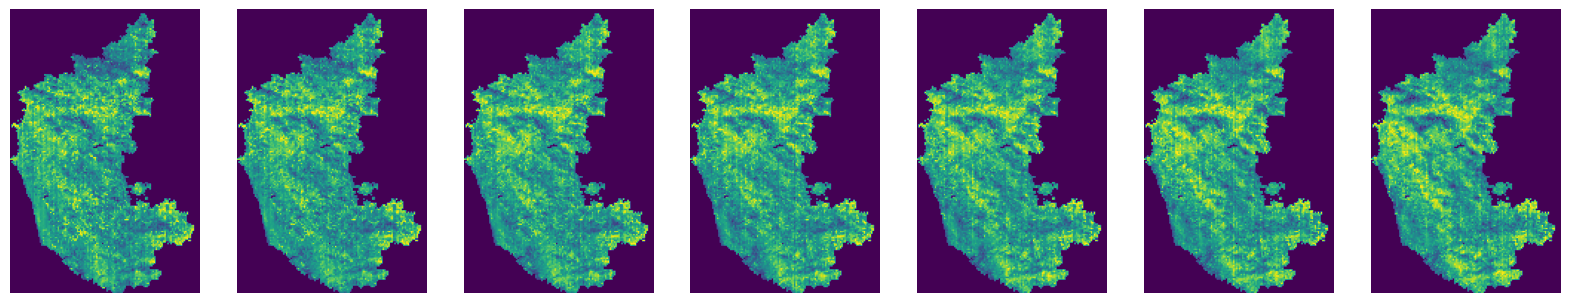

In [ ]:
from matplotlib import pyplot
idx = np.random.randint(0, len(dataset[0]),7)
plt.figure(figsize=(20,20))
for i in range(len(idx)):
    #define subplot
    pyplot.subplot(1,7,1+i)
    #turn off acis
    pyplot.axis('off')
    #plot raw pixel data
    pyplot.imshow(dataset[0][i].reshape(192,128))
    #show title
    #pyplot.title(titles[i])
pyplot.show()

## Sampling temporally to feed to LSTM

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y), n_steps

In [ ]:
dataset = load_real_samples("F:\Jyoti Shukla -MS\karnataka dataset\paired_padded_arrays_train_total_AVHRR_data.npz")
dataset_test = load_real_samples("F:\Jyoti Shukla -MS\karnataka dataset\paired_padded_arrays_test_total_AVHRR_data.npz")
train_dataset, train_labels = dataset[0],dataset[1]
test_dataset, test_labels = dataset_test[0], dataset_test[1]
# Inspect the dataset.
print("Training Dataset Shapes: " + str(train_dataset.shape) + ", " + str(train_labels.shape))
print("Validation Dataset Shapes: " + str(test_dataset.shape) + ", " + str(test_labels.shape))

Training Dataset Shapes: (2069, 192, 128, 1), (2069, 192, 128, 1)
Validation Dataset Shapes: (52, 192, 128, 1), (52, 192, 128, 1)


In [ ]:
dataset = load_real_samples("F:\Jyoti Shukla -MS\karnataka dataset\paired_padded_arrays_train_AVHRR_data.npz")
dataset_test = load_real_samples("F:\Jyoti Shukla -MS\karnataka dataset\paired_padded_arrays_test_AVHRR_data.npz")
train_dataset, train_labels = dataset[0],dataset[1]
test_dataset, test_labels = dataset_test[0], dataset_test[1]
# Inspect the dataset.
print("Training Dataset Shapes: " + str(train_dataset.shape) + ", " + str(train_labels.shape))
print("Validation Dataset Shapes: " + str(test_dataset.shape) + ", " + str(test_labels.shape))

Training Dataset Shapes: (1899, 192, 128, 1), (1899, 192, 128, 1)
Validation Dataset Shapes: (60, 192, 128, 1), (60, 192, 128, 1)


In [ ]:
x_train, y_train, n_steps = split_sequence(train_dataset, 4)
x_test, y_test, n_steps = split_sequence(test_dataset,4)
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_test.shape) + ", " + str(y_test.shape))

Training Dataset Shapes: (2065, 4, 192, 128, 1), (2065, 192, 128, 1)
Validation Dataset Shapes: (48, 4, 192, 128, 1), (48, 192, 128, 1)


## ConvLSTM with Conv3D

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[i+1:end_ix+1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y), n_steps

In [ ]:
x_train, y_train, n_steps = split_sequence(train_dataset, 4)
x_test, y_test, n_steps = split_sequence(test_dataset,4)
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_test.shape) + ", " + str(y_test.shape))

Training Dataset Shapes: (2065, 4, 192, 128, 1), (2065, 4, 192, 128, 1)
Validation Dataset Shapes: (48, 4, 192, 128, 1), (48, 4, 192, 128, 1)


## Convlstm and conv3d

In [ ]:
inp = layers.Input(shape=(None, *x_train.shape[2:]))
inp.shape

TensorShape([None, None, 190, 124, 1])

In [ ]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
#x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)
x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
#x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)
#x = layers.Dropout(0.3)(x)

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
#x = layers.Dropout(0.3)(x)
#x = layers.UpSampling3D((2, 2,2))(x)

x = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)

x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
#x = layers.UpSampling3D((2, 2,2))(x)
# x = layers.Dropout(0.3)(x)
x = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss='mse', optimizer=keras.optimizers.SGD(learning_rate=0.1),metrics=[tf.keras.metrics.mse]
)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, 256, 256,   0         
                             1)]                                 
                                                                 
 conv_lstm2d_16 (ConvLSTM2D)  (None, None, 256, 256, 1  9856     
                             6)                                  
                                                                 
 batch_normalization_13 (Bat  (None, None, 256, 256, 1  64       
 chNormalization)            6)                                  
                                                                 
 conv_lstm2d_17 (ConvLSTM2D)  (None, None, 256, 256, 3  55424    
                             2)                                  
                                                                 
 batch_normalization_14 (Bat  (None, None, 256, 256, 3  128

In [ ]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 30
batch_size = 2

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/30
43/43 [==============================] - 215s 5s/step - loss: 0.0646 - cosine_similarity: 0.8949 - val_loss: 0.0557 - val_cosine_similarity: 0.9113 - lr: 0.1000
Epoch 2/30
43/43 [==============================] - 200s 5s/step - loss: 0.0598 - cosine_similarity: 0.9002 - val_loss: 0.0558 - val_cosine_similarity: 0.9112 - lr: 0.1000
Epoch 3/30
43/43 [==============================] - 200s 5s/step - loss: 0.0534 - cosine_similarity: 0.9122 - val_loss: 0.0561 - val_cosine_similarity: 0.9112 - lr: 0.1000
Epoch 4/30
43/43 [==============================] - 200s 5s/step - loss: 0.0442 - cosine_similarity: 0.9279 - val_loss: 0.0565 - val_cosine_similarity: 0.9111 - lr: 0.1000
Epoch 5/30
43/43 [==============================] - 200s 5s/step - loss: 0.0358 - cosine_similarity: 0.9402 - val_loss: 0.0564 - val_cosine_similarity: 0.9112 - lr: 0.1000
Epoch 6/30
43/43 [==============================] - 200s 5s/step - loss: 0.0315 - cosine_similarity: 0.9481 - val_loss: 0.0551 - val_cosine_

In [ ]:
model.save("/content/drive/MyDrive/DATA_GAN/Models_by_convlstm_con3d/convlstm_conv3d_morelayers_30epochs.h5")

In [ ]:
model.save("/content/drive/MyDrive/DATA_GAN/Models_by_convlstm_con3d/convlstm_conv3d_70epochs.h5")

In [ ]:
from keras.models import load_model
model_1 = load_model("/content/drive/MyDrive/DATA_GAN/Models_by_convlstm_con3d/convlstm_conv3d_70epochs.h5")
model_2= load_model("/content/drive/MyDrive/DATA_GAN/Models_by_convlstm_con3d/convlstm_conv3d_morelayers_30epochs.h5")

In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 256, 256,   0         
                             1)]                                 
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, None, 256, 256, 1  9856      
                             6)                                  
                                                                 
 batch_normalization_4 (Batc  (None, None, 256, 256, 1  64       
 hNormalization)             6)                                  
                                                                 
 conv_lstm2d_6 (ConvLSTM2D)  (None, None, 256, 256, 3  55424     
                             2)                                  
                                                                 
 batch_normalization_5 (Batc  (None, None, 256, 256, 3  128

In [ ]:
framed = x_test[3][:1,...]
pred = model.predict(np.expand_dims(framed, axis=0))
y_real = y_test[3][0]
pred = pred.reshape(256,256,1)
plt.imshow(pred.reshape(256,256))
plt.figure()
plt.imshow(y_real.reshape(256,256))

ValueError: ignored

In [ ]:
np.max(pred),np.max(y_real)

(0.5000752, 1.0000000000000004)

In [ ]:
#extracting predicted frame from every series of 4 images
test_predicted = model_1.predict(x_test)
#predicted.shape[0]
p =[]
for i in range(test_predicted.shape[0]):
  arr = test_predicted[i][0]
  p.append(arr)
test_set = np.asarray(p)
test_set.shape

(17, 256, 256, 1)

In [ ]:
train_predicted = model.predict(x_train)
p=[]
for i in range(train_predicted.shape[0]):
  arr = train_predicted[i][0]
  p.append(arr)
train_set = np.asarray(p)
train_set.shape

(86, 256, 256, 1)

In [ ]:
#save the temporal values in txt file
# saving the temporal features values
train_file = open("/content/drive/MyDrive/DATA_GAN/Models_by_convlstm_con3d/train_lstm3D.txt","w")
for i in range(train_set.shape[0]):
  array = train_set[i].reshape(256,256)
  np.savetxt(train_file,array)
train_file.close()

test_file = open("/content/drive/MyDrive/DATA_GAN/Models_by_convlstm_con3d/test_lstm3D.txt","w")
for i in range(test_set.shape[0]):
  array = test_set[i].reshape(256,256)
  np.savetxt(test_file,array)
test_file.close()


In [ ]:
example = x_test[np.random.choice(range(len(x_test)), size=1)[0]]
frames = example[:2, ...]
original_frames = example[2:, ...]

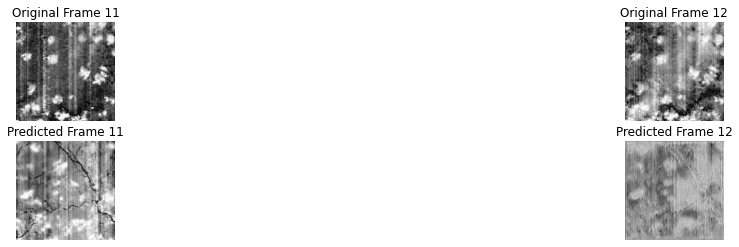

In [ ]:
# Predict a new set of 10 frames.
for _ in range(2):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 2, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Original Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[1:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Predicted Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

In [ ]:
original_frames[1]

In [ ]:
frames[0]

In [ ]:
frames[1]

In [ ]:
frames[2]

In [ ]:
frames[3]

## ABOVE MODEL WITH HUBER LOSS

In [ ]:
inp = layers.Input(shape=(None, *x_train.shape[2:]))
inp.shape

TensorShape([None, None, 192, 128, 1])

In [ ]:
x = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
#x = layers.BatchNormalization()(x)
x = tfa.layers.GroupNormalization(groups =16)(x)
#x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)
x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
#x = layers.BatchNormalization()(x)
x = tfa.layers.GroupNormalization(groups =16)(x)
#x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)
x = layers.Dropout(0.3)(x)

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
#x = layers.BatchNormalization()(x)
x = tfa.layers.GroupNormalization(groups =16)(x)
#x = layers.Dropout(0.3)(x)
#x = layers.UpSampling3D((2, 2,2))(x)

x = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = tfa.layers.GroupNormalization(groups =128)(x)
#x = layers.BatchNormalization()(x)

# x = layers.ConvLSTM2D(
#     filters=256,
#     kernel_size=(3, 3),
#     padding="same",
#     return_sequences=True,
#     activation="relu",
# )(x)
# x = tfa.layers.GroupNormalization(groups =64)(x)

x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)

x = tfa.layers.GroupNormalization(groups =16)(x)
#x = layers.UpSampling3D((2, 2, 2))(x)
# x = layers.Dropout(0.3)(x)
x = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
#x = layers.BatchNormalization()(x)
x = tfa.layers.GroupNormalization(groups =16)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)
huber_loss = tf.keras.losses.Huber(delta=0.01)
# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss= huber_loss, optimizer=keras.optimizers.SGD(learning_rate=0.1),metrics=[tf.keras.metrics.mse]
)
model.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 192, 128, 1 0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, None, 192, 128, 16 9856      
_________________________________________________________________
group_normalization (GroupNo (None, None, 192, 128, 16 32        
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 192, 128, 32 55424     
_________________________________________________________________
group_normalization_1 (Group (None, None, 192, 128, 32 64        
_________________________________________________________________
dropout (Dropout)            (None, None, 192, 128, 32 0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 192, 128, 64 221440

In [ ]:
train = x_train[:10]
train_y = y_train[:10]
test = x_test[:5]
test_y = y_test[:5]

In [ ]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 30
batch_size = 1

# Fit the model to the training data.
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr],
)

model.save("F:\Jyoti Shukla -MS\codes\Saved models and history AVHRR/convlstm_conv3d_AVHRR_model.h5")

# Results of updated model
np.save('F:\Jyoti Shukla -MS\codes\Saved models and history AVHRR/convlstm_conv3d_AVHRR_model_history.npy',history.history)

## With K-Fold Validation

In [ ]:
#from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold
import tensorflow_addons as tfa
from sklearn.model_selection import GridSearchCV

def baseline_model():
    inp = layers.Input(shape=(None, *x_train.shape[2:]))
    x = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
    )(inp)
    #x = layers.BatchNormalization()(x)
    x = tfa.layers.GroupNormalization(groups =4)(x)
    #x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)
    x = layers.ConvLSTM2D(
        filters=32,
        kernel_size=(3, 3),
        padding="same",
        return_sequences=True,
        activation="relu",
    )(x)
    #x = layers.BatchNormalization()(x)
    x = tfa.layers.GroupNormalization(groups =8)(x)
    #x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)
    x = layers.Dropout(0.3)(x)

    # x = layers.ConvLSTM2D(
    #     filters=64,
    #     kernel_size=(3, 3),
    #     padding="same",
    #     return_sequences=True,
    #     activation="relu",
    # )(x)
    # #x = layers.BatchNormalization()(x)
    # x = tfa.layers.GroupNormalization(groups =16)(x)
    #x = layers.Dropout(0.3)(x)
    #x = layers.UpSampling3D((2, 2,2))(x)

    # x = layers.ConvLSTM2D(
    #     filters=128,
    #     kernel_size=(3, 3),
    #     padding="same",
    #     return_sequences=True,
    #     activation="relu",
    # )(x)
    # x = tfa.layers.GroupNormalization(groups =32)(x)
    # #x = layers.BatchNormalization()(x)

    # x = layers.ConvLSTM2D(
    #     filters=256,
    #     kernel_size=(3, 3),
    #     padding="same",
    #     return_sequences=True,
    #     activation="relu",
    # )(x)
    # x = tfa.layers.GroupNormalization(groups =64)(x)

    x = layers.ConvLSTM2D(
        filters=32,
        kernel_size=(3, 3),
        padding="same",
        return_sequences=True,
        activation="relu",
    )(x)

    x = tfa.layers.GroupNormalization(groups =8)(x)
    #x = layers.UpSampling3D((2, 2, 2))(x)
    # x = layers.Dropout(0.3)(x)
    x = layers.ConvLSTM2D(
        filters=16,
        kernel_size=(3, 3),
        padding="same",
        return_sequences=True,
        activation="relu",
    )(x)
    #x = layers.BatchNormalization()(x)
    x = tfa.layers.GroupNormalization(groups =4)(x)
    x = layers.Conv3D(
        filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
    )(x)
    huber_loss = tf.keras.losses.Huber(delta=0.01)
    # Next, we will build the complete model and compile it.
    model = keras.models.Model(inp, x)
    model.compile(
        loss= huber_loss, optimizer=keras.optimizers.SGD(learning_rate=0.1),metrics=[tf.keras.metrics.mse]
    )
    return model

# evaluate model
epochs = [1, 2, 3]
model = KerasRegressor(build_fn=baseline_model)
param_grid = dict(epochs=epochs)
#estimator = baseline_model()
# kfold = KFold(n_splits=2)
# results = cross_val_score(estimator, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
# print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

PicklingError: Could not pickle the task to send it to the workers.

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor

model loading

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import History
from tensorflow import keras
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
model= load_model("F:\Jyoti Shukla -MS\codes\Saved models and history AVHRR_total\convlstm_conv3d_AVHRR_total_model_6.1.h5")
history=np.load('F:\Jyoti Shukla -MS\codes\Saved models and history AVHRR_total\convlstm_conv3d_AVHRR_total_model_6.1_history.npy',allow_pickle='TRUE').item()

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 192, 128, 1 0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, None, 192, 128, 16 9856      
_________________________________________________________________
group_normalization (GroupNo (None, None, 192, 128, 16 32        
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 192, 128, 64 184576    
_________________________________________________________________
group_normalization_1 (Group (None, None, 192, 128, 64 128       
_________________________________________________________________
dropout (Dropout)            (None, None, 192, 128, 64 0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 192, 128, 12 885248

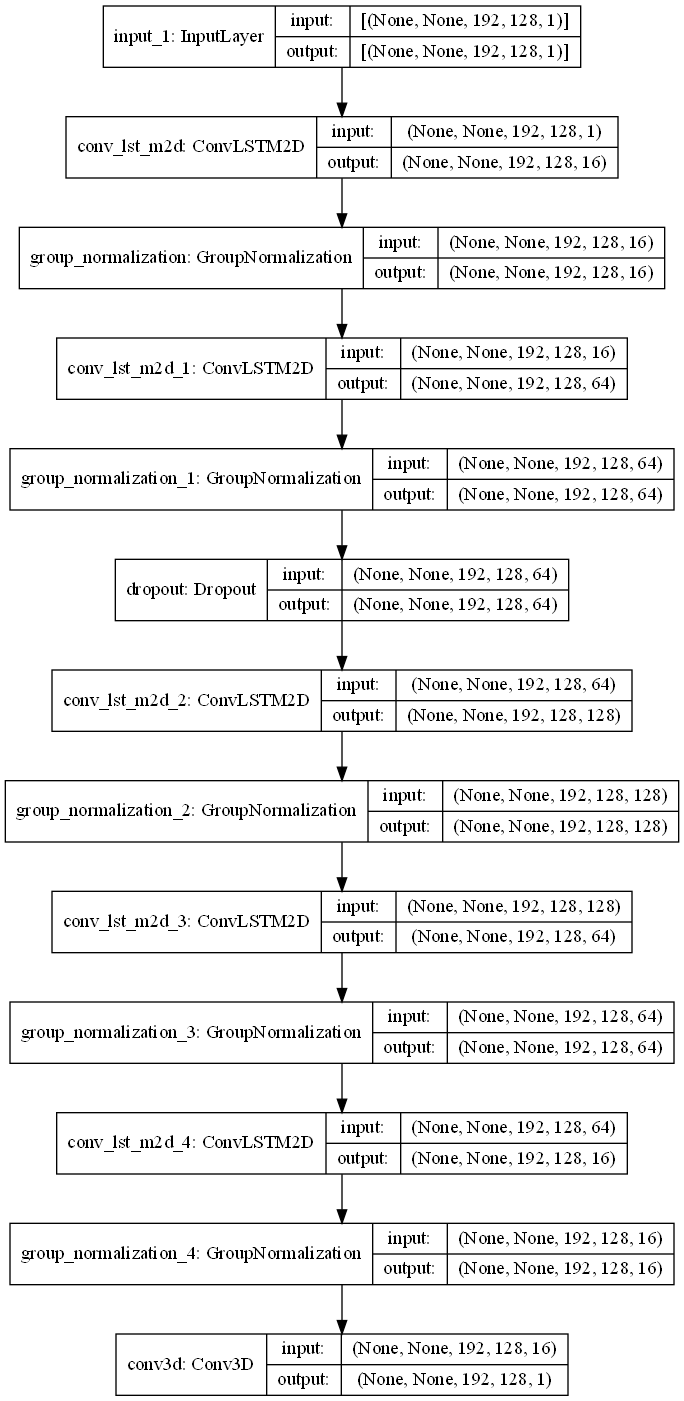

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
history.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error', 'lr'])

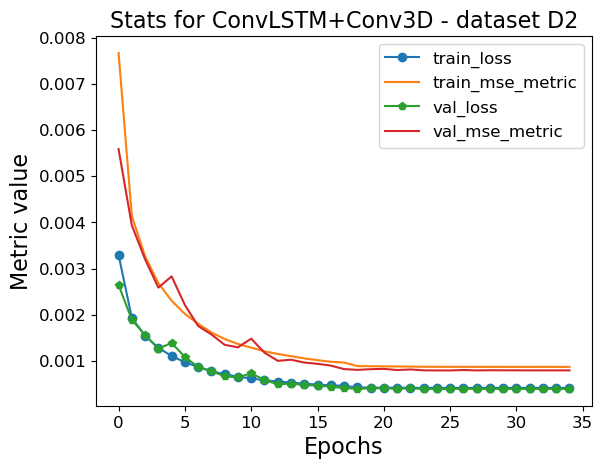

In [ ]:
# Results of updated model

plt.plot(history['loss'],'-o')
plt.plot(history['mean_squared_error'])
plt.plot(history['val_loss'],'-p')
plt.plot(history['val_mean_squared_error'])


plt.title('Stats for ConvLSTM+Conv3D - dataset D2', fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('Metric value', fontsize = 16)
plt.legend(['train_loss','train_mse_metric','val_loss','val_mse_metric'], fontsize = 12)
plt.show()

In [ ]:
tf.function(experimental_relax_shapes=True)

<function tensorflow.python.eager.def_function.function.<locals>.decorated(inner_function)>

mse 0.0110770445
r2 score is: 0.8446067400614233 

discrete values, predicted and real respectively: 0.6470381 0.6838


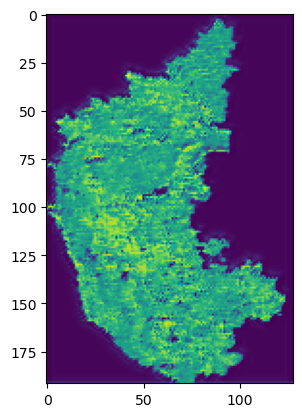

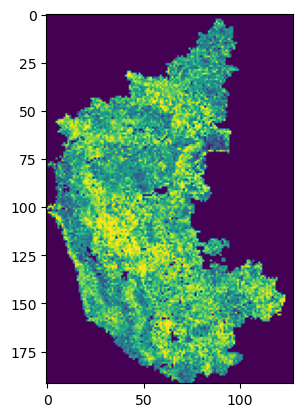

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
framed = x_test[36][2:3,...]
pred = model.predict(np.expand_dims(framed, axis=0))
y_real = y_test[36][2]
pred = pred.reshape(192,128,1)
plt.imshow(pred.reshape(192,128))
plt.figure()
plt.imshow(y_real.reshape(192,128))
r2 = r2_score(y_real.reshape(192,128),pred.reshape(192,128))
mse = mse(y_real.reshape(192,128),pred.reshape(192,128))
print("mse",mse)
print("r2 score is:", r2,"\n")
pred = pred.reshape(192,128)
y_real = y_real.reshape(192,128)
print("discrete values, predicted and real respectively:",(pred.reshape(192,128))[50][30],(y_real.reshape(192,128))[50][30])

ValueError: cannot reshape array of size 24576 into shape (190,124)

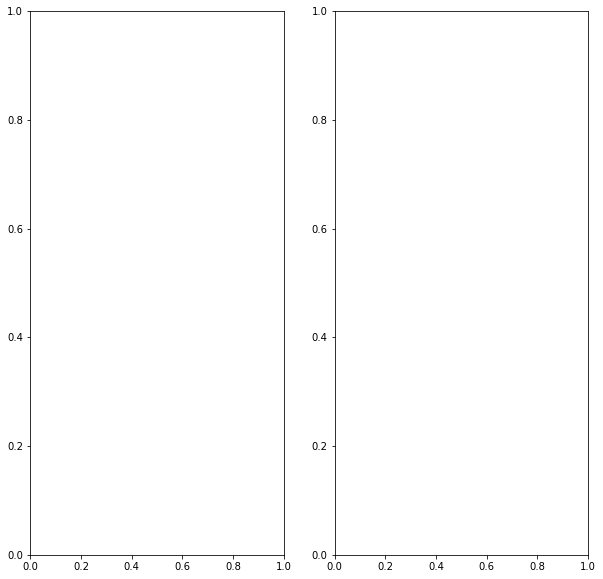

In [ ]:
unscale_pred = unscale(pred,vhi_test_label[36][2])
unscale_real = unscale(y_real,vhi_test_label[36][2])
colorcoded_pred = colorcoding(unscale_pred)
colorcoded_real = colorcoding(unscale_real)
images = [colorcoded_real, colorcoded_pred]
titles =["Real","Predicted"]
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
for i in range(len(images)):
    pos = ax[i].imshow(images[i].reshape(190,124), cmap="rainbow")
    #ax.set_title(f"Original Frame {idx}")
    cax = fig.add_axes([ax[i].get_position().x1+0.01,ax[i].get_position().y0,0.02,ax[i].get_position().height])
    fig.colorbar(pos, ax = ax[i], cax =cax)
    ax[i].set_title(titles[i])
    #ax.axis("off")
fig.suptitle("ConvLSTM+Conv3D Outputs")

In [ ]:
pred = pred.reshape(190,124)
y_real = y_real.reshape(190,124)
print((pred.reshape(190,124))[50][30],(y_real.reshape(190,124))[50][30])

0.86777866 0.7555999755859375


For total data

mse 0.0110770445
r2 score is: 0.8446067400614233 

discrete values, predicted and real respectively: 0.6470381 0.6838


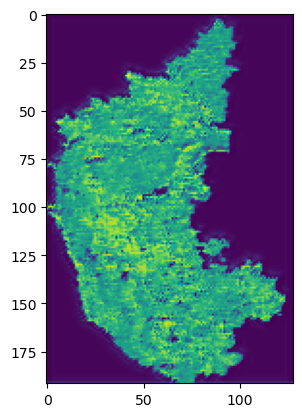

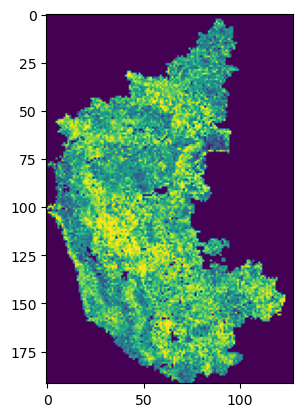

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
framed = x_test[36][2:3,...]
pred = model.predict(np.expand_dims(framed, axis=0))
y_real = y_test[36][2]
pred = pred.reshape(192,128,1)
plt.imshow(pred.reshape(192,128))
plt.figure()
plt.imshow(y_real.reshape(192,128))
r2 = r2_score(y_real.reshape(192,128),pred.reshape(192,128))
mse = mse(y_real.reshape(192,128),pred.reshape(192,128))
print("mse",mse)
print("r2 score is:", r2,"\n")
pred = pred.reshape(192,128)
y_real = y_real.reshape(192,128)
print("discrete values, predicted and real respectively:",(pred.reshape(192,128))[50][30],(y_real.reshape(192,128))[50][30])

Text(0.5, 0.98, 'ConvLSTM+Conv3D Outputs')

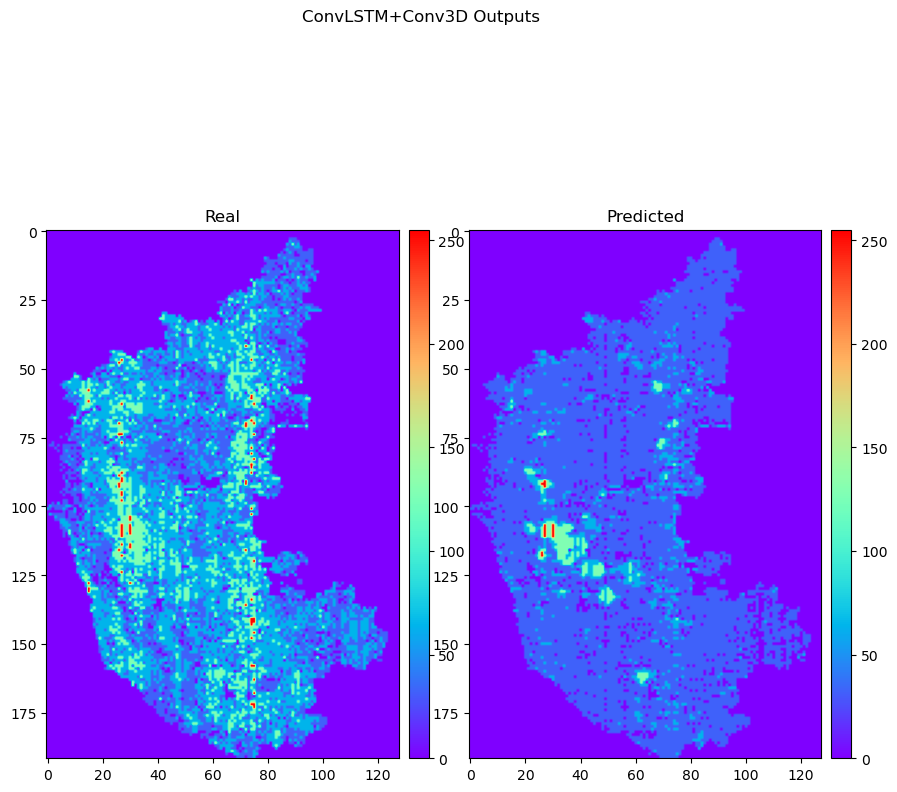

In [ ]:
unscale_pred = unscale(pred,vhi_test_label[36][2])
unscale_real = unscale(y_real,vhi_test_label[36][2])
colorcoded_pred = colorcoding(unscale_pred)
colorcoded_real = colorcoding(unscale_real)
images = [colorcoded_real, colorcoded_pred]
titles =["Real","Predicted"]
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
for i in range(len(images)):
    pos = ax[i].imshow(images[i].reshape(192,128), cmap="rainbow")
    #ax.set_title(f"Original Frame {idx}")
    cax = fig.add_axes([ax[i].get_position().x1+0.01,ax[i].get_position().y0,0.02,ax[i].get_position().height])
    fig.colorbar(pos, ax = ax[i], cax =cax)
    ax[i].set_title(titles[i])
    #ax.axis("off")
fig.suptitle("ConvLSTM+Conv3D Outputs")

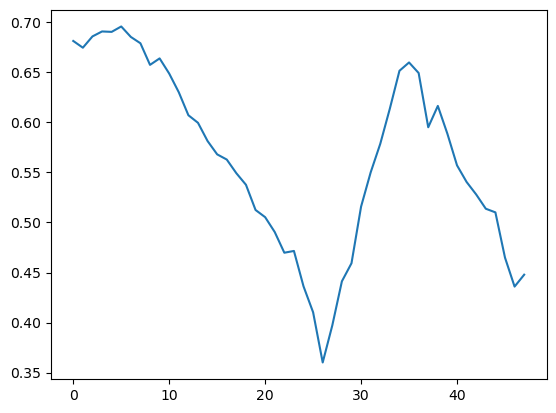

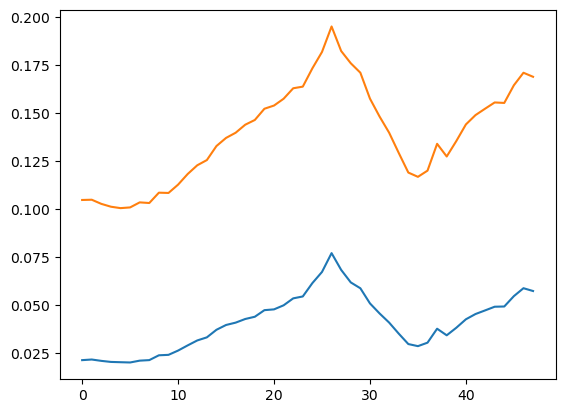

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
data = x_test
label = y_test
predicted =[]
true = []
R2 =[]
res = []
MSE =[]
for i in range(len(data)):
    #for j in range(4):
    framed = data[i][0]
    y_real = label[i][0].reshape(192,128)
    test = framed.reshape(1,1,192,128,1)
    pred = model.predict(test)
    pred = pred.reshape(192,128)
    r2 = r2_score(y_real,pred)
    residual = mae(y_real,pred)
    err = mse(y_real,pred)
    MSE.append(err)
    res.append(residual)
    predicted.append(pred)
    true.append(y_real)
    R2.append(r2)
plt.plot(R2)
plt.show()
plt.plot(MSE)
plt.plot(res)
np.save()

In [ ]:
np.mean(R2), np.max(R2), np.mean(res), np.mean(MSE)

(0.5637906078618082, 0.6958948029626632, 0.13914718, 0.041057866)

## LR Trial

In [ ]:
# pred = pred.flatten()
# y_real= y_real.flatten()
from sklearn.linear_model import LinearRegression
mod = LinearRegression().fit(pred,y_real)
r_sq = mod.score(pred,y_real)
coef = mod.coef_
intercept = mod.intercept_
print(coef.shape)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {mod.intercept_}")
print(f"slope: {mod.coef_}")

(124, 124)
coefficient of determination: 0.9864454655997172
intercept: [-0.03918012 -0.05821887 -0.01968738 -0.03113922 -0.04394657 -0.03886133
  0.02974238 -0.02001564 -0.05447686  0.01001643  0.07383002 -0.03844599
  0.03089428  0.13322137  0.07611212  0.03606588  0.00854969  0.01859784
  0.07428735  0.02239516  0.04331639  0.04521036  0.00475538 -0.02670798
 -0.06129897 -0.07926312 -0.06343377 -0.05272245 -0.04072645 -0.04168999
 -0.10615626 -0.0510827   0.00450006 -0.01799846  0.02627289  0.0633949
  0.05338553  0.09494111 -0.00571108 -0.01648021 -0.11916798 -0.13389629
 -0.09158874 -0.03772599 -0.00871044 -0.04668289  0.03520465 -0.03614342
 -0.08865058 -0.14718121 -0.02666748  0.01203138 -0.05985934 -0.00685692
 -0.06856227  0.0145179  -0.00479013 -0.05616802 -0.0048489   0.02796584
  0.00985801  0.03221816  0.04145044  0.04809272 -0.02850169  0.00969988
 -0.1293034  -0.12764251 -0.06628299 -0.07218599 -0.16153115 -0.10444611
 -0.09171373 -0.0853548  -0.21520942 -0.0555954   0.09

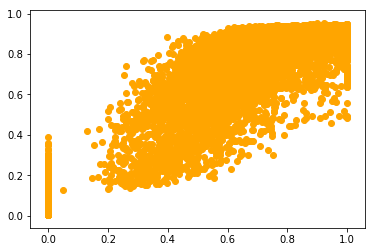

In [ ]:

#plt.scatter(x,pred,colour='yellow')
#plt.plot(r_sq, color = 'yellow')
plt.scatter(y_real,pred, color ='orange')
plt.show()


In [ ]:
y_mean = np.mean()

## Calculating metrics

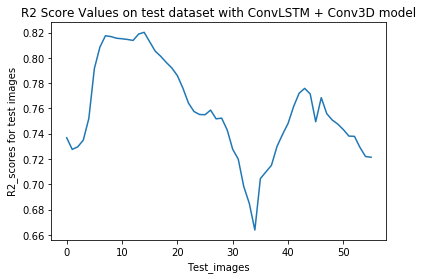

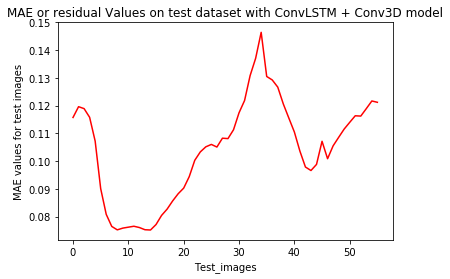

Text(0.5,1,'MSE Values on test dataset with ConvLSTM + Conv3D model')

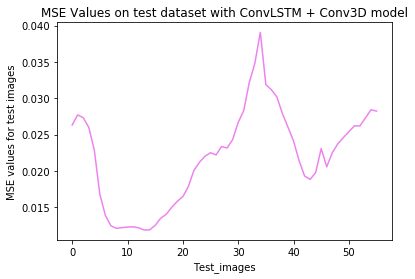

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
data = x_test
label = y_test
predicted =[]
true = []
R2 =[]
res = []
MSE =[]
for i in range(len(data)):
    #for j in range(4):
    framed = data[i][0]
    y_real = label[i][0].reshape(190,124)
    test = framed.reshape(1,1,190,124,1)
    pred = model.predict(test)
    pred = pred.reshape(190,124)
    r2 = r2_score(y_real,pred)
    residual = mae(y_real,pred)
    err = mse(y_real,pred)
    MSE.append(err)
    res.append(residual)
    predicted.append(pred)
    true.append(y_real)
    R2.append(r2)
plt.plot(R2)
plt.xlabel("Test_images")
plt.ylabel("R2_scores for test images")
plt.title("R2 Score Values on test dataset with ConvLSTM + Conv3D model")
plt.show()
plt.plot(res,color='red')
plt.xlabel("Test_images")
plt.ylabel("MAE values for test images")
plt.title("MAE or residual Values on test dataset with ConvLSTM + Conv3D model")
plt.show()
plt.plot(MSE, 'violet')
plt.xlabel("Test_images")
plt.ylabel("MSE values for test images")
plt.title("MSE Values on test dataset with ConvLSTM + Conv3D model")

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
data = x_test
label = y_test
predicted =[]
true = []
R2 =[]
res = []
MSE =[]
for i in range(len(data)):
    #for j in range(4):
    framed = data[i][0]
    y_real = label[i][0].reshape(190,124)
    test = framed.reshape(1,1,190,124,1)
    pred = model.predict(test)
    pred = pred.reshape(190,124)
    r2 = r2_score(y_real,pred)
    residual = mae(y_real,pred)
    err = mse(y_real,pred)
    MSE.append(err)
    res.append(residual)
    predicted.append(pred)
    true.append(y_real)
    R2.append(r2)

np.save("R2_score_convLSTM+conv3D_2.1.npy", R2)
np.save("MAE_for_ConvLSTM+ Conv3D_2.1.npy",res)
np.save("MSE_for_ConvLSTM+Conv3D_2.1.npy",MSE)
np.save("Predicted_outputs_ConvLSTM+Conv3D_2.1.npy", predicted)


# r2 = r2_score(y_real, pred)
print(len(R2))
print('r2 score for test data on model is: \n', R2)

56
r2 score for test data on model is: 
 [0.8073175701323676, 0.8251750907536042, 0.8224152095092531, 0.8107972363704404, 0.7789325548785869, 0.6796708664736253, 0.5687652148221054, 0.4868519709840127, 0.43346122561088557, 0.42090770561927615, 0.42443150229872334, 0.42445138653072095, 0.41256720249097817, 0.4229381885995474, 0.44234651419401944, 0.4231804512606754, 0.4699007614615398, 0.5172804625975578, 0.5809389077884852, 0.625649168684577, 0.6489781788541796, 0.6834676023514547, 0.7294716499564982, 0.7539807569907604, 0.771958602493968, 0.7878849597685763, 0.7921237714857405, 0.8005101461354521, 0.8001459057826563, 0.8007980412376356, 0.8103319432290863, 0.8171308303178534, 0.8334501368035729, 0.8467779756398192, 0.8632226039853311, 0.8227938577907713, 0.8288121785641804, 0.8211551605513105, 0.788499341095668, 0.7668704572334495, 0.7413044169391605, 0.6964680591297753, 0.6466070739657668, 0.6377715370556296, 0.65717760808211, 0.7326534349697047, 0.6887921257432573, 0.738094090124802

In [ ]:
R2[32:35], res[32:35], MSE[32:35]

([0.8334501368035729, 0.8467779756398192, 0.8632226039853311],
 [0.07303050926665298, 0.06865358454923108, 0.06339287917060174],
 [0.01296916181223915, 0.011827658293455801, 0.01053523304207846])

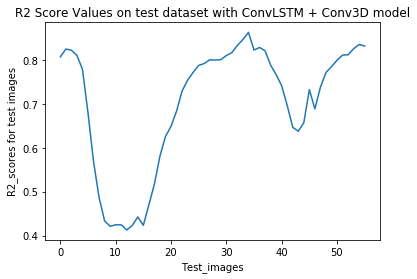

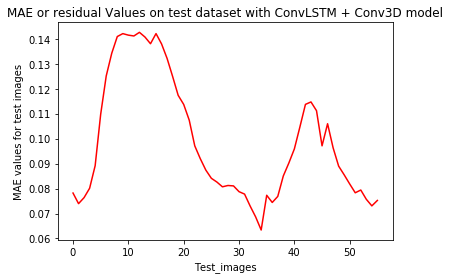

Text(0.5,1,'MSE Values on test dataset with ConvLSTM + Conv3D model')

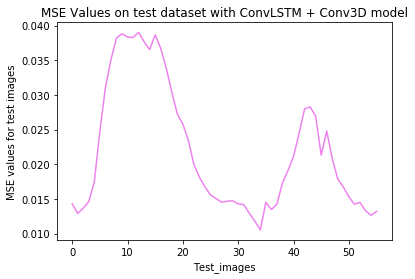

In [ ]:
R2 = np.load("R2_score_convLSTM+conv3D_2.1.npy")
res = np.load("MAE_for_ConvLSTM+ Conv3D_2.1.npy")
MSE = np.load("MSE_for_ConvLSTM+Conv3D_2.1.npy")
plt.plot(R2)
plt.xlabel("Test_images")
plt.ylabel("R2_scores for test images")
plt.title("R2 Score Values on test dataset with ConvLSTM + Conv3D model")
plt.show()
plt.plot(res,color='red')
plt.xlabel("Test_images")
plt.ylabel("MAE values for test images")
plt.title("MAE or residual Values on test dataset with ConvLSTM + Conv3D model")
plt.show()
plt.plot(MSE, 'violet')
plt.xlabel("Test_images")
plt.ylabel("MSE values for test images")
plt.title("MSE Values on test dataset with ConvLSTM + Conv3D model")

In [ ]:
print(R2)

[0.80731757 0.82517509 0.82241521 0.81079724 0.77893255 0.67967087
 0.56876521 0.48685197 0.43346123 0.42090771 0.4244315  0.42445139
 0.4125672  0.42293819 0.44234651 0.42318045 0.46990076 0.51728046
 0.58093891 0.62564917 0.64897818 0.6834676  0.72947165 0.75398076
 0.7719586  0.78788496 0.79212377 0.80051015 0.80014591 0.80079804
 0.81033194 0.81713083 0.83345014 0.84677798 0.8632226  0.82279386
 0.82881218 0.82115516 0.78849934 0.76687046 0.74130442 0.69646806
 0.64660707 0.63777154 0.65717761 0.73265343 0.68879213 0.73809409
 0.77172255 0.78491945 0.79953074 0.81137711 0.81203088 0.82584551
 0.83547949 0.83208384]


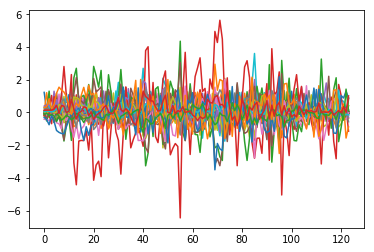

(124, 124)

In [ ]:
slope = mod.coef_
plt.plot(slope)
plt.show()
slope.shape

In [ ]:
example = x_train[np.random.choice(range(len(x_test)), size=1)[0]]
frames = example[:3, ...]
original_frames = example[1:, ...]

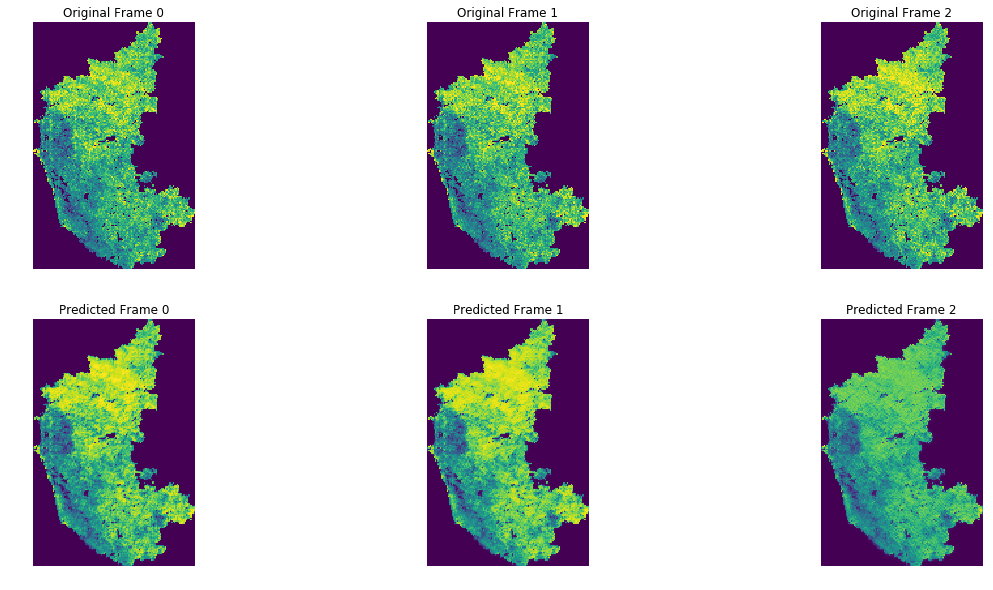

In [ ]:
# Predict a new set of 10 frames.
example = x_test[np.random.choice(range(len(x_test)), size=1)[0]]
frames = example[:3, ...]
original_frames = example[1:, ...]
for _ in range(3):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)
#print(frames.shape)
# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]))
    ax.set_title(f"Original Frame {idx}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[3:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]))
    ax.set_title(f"Predicted Frame {idx}")
    ax.axis("off")

# Display the figure.
plt.show()

In [ ]:
# unscaling values
def unscale(mat, VHI_test):
  scaler = MinMaxScaler()
  scaled = scaler.fit_transform(VHI_test)
  unscaled = scaler.inverse_transform(mat.reshape(192,128))
  return unscaled

In [ ]:
def colorcoding(mat):
  for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
      #print(mat[i][j])
      if  mat[i][j] >80:
        mat[i][j] = 255
      # elif (mat[i][j]<80) &(mat[i][j] >70):             # Abnormally Dry
      #   mat[i][j]= 128
      elif (mat[i][j]<80) &(mat[i][j] >60):             # Abnormally Dry
        mat[i][j]= 128
      # elif (mat[i][j]<60) &(mat[i][j] >50):             # Abnormally Dry
      #   mat[i][j]= 64
      elif (mat[i][j]<60) &(mat[i][j] >40):             # Abnormally Dry
        mat[i][j]= 64
      # elif (mat[i][j]<40) &(mat[i][j] >30):             # Abnormally Dry
      #   mat[i][j]= 16
      elif (mat[i][j]<40) &(mat[i][j]>20):              # Moderate drought
        mat[i][j] = 32
      # elif (mat[i][j]<20) & (mat[i][j]>10):             # Severe drought
      #   mat[i][j] = 4
      elif (mat[i][j])<20:                              # Extreme  drought
        mat[i][j]= 0
  return mat

In [ ]:
#real unscaled data
VHI_train = np.loadtxt(r"F:\Jyoti Shukla -MS\karnataka dataset/Train_AVHRR_data_1981_2022.txt").reshape(1900,190,124)
VHI_test = np.loadtxt(r"F:\Jyoti Shukla -MS\karnataka dataset\Test_AVHRR_data_1981_2022.txt").reshape(61,190,124)
VHI_train = np.where(VHI_train<0,0,VHI_train)
VHI_test = np.where(VHI_test<0,0,VHI_test)
print(VHI_train.shape, VHI_test.shape)
print(np.max(VHI_train), np.min(VHI_train), np.max(VHI_test),np.min(VHI_test))

(1900, 190, 124) (61, 190, 124)
100.0 0.0 100.0 0.0


In [ ]:
#real unscaled data
VHI_train = np.loadtxt(r"F:\Jyoti Shukla -MS\karnataka dataset\Padded_Train_total_AVHRR_data_1981_2022.txt").reshape(2070,192,128)
VHI_test = np.loadtxt(r"F:\Jyoti Shukla -MS\karnataka dataset\Padded_Test_total_AVHRR_data_1981_2022.txt").reshape(53,192,128)
VHI_train = np.where(VHI_train<0,0,VHI_train)
VHI_test = np.where(VHI_test<0,0,VHI_test)
print(VHI_train.shape, VHI_test.shape)
print(np.max(VHI_train), np.min(VHI_train), np.max(VHI_test),np.min(VHI_test))

(2070, 192, 128) (53, 192, 128)
100.0 0.0 100.0 0.0


In [ ]:
x = VHI_train[:-1]
y = VHI_train[1:]
#np.savez("F:\Jyoti Shukla -MS\karnataka dataset/paired_unscaled_arrays_train_AVHRR_data.npz",x = x , y = y)
np.savez("F:\Jyoti Shukla -MS\karnataka dataset\Padded_paired_unscaled_train_total_AVHRR_data_1981_2022.npz", x = x, y =y)

x = VHI_test[:-1]
y = VHI_test[1:]
#np.savez("F:\Jyoti Shukla -MS\karnataka dataset/paired_unscaled_arrays_test_AVHRR_data.npz",x = x , y = y)
np.savez("F:\Jyoti Shukla -MS\karnataka dataset\Padded_paired_unscaled_test_total_AVHRR_data_1981_2022.npz", x = x, y =y)


In [ ]:
#data_train = load_real_samples("F:\Jyoti Shukla -MS\karnataka dataset/paired_unscaled_arrays_train_AVHRR_data.npz")
#data_test = load_real_samples("F:\Jyoti Shukla -MS\karnataka dataset/paired_unscaled_arrays_test_AVHRR_data.npz")
data_train = load_real_samples("F:\Jyoti Shukla -MS\karnataka dataset\Padded_paired_unscaled_train_total_AVHRR_data_1981_2022.npz")
data_test = load_real_samples("F:\Jyoti Shukla -MS\karnataka dataset\Padded_paired_unscaled_test_total_AVHRR_data_1981_2022.npz")
train_data, train_label = data_train[0], data_train[1]
test_data, test_label = data_test[0], data_test[1]
print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)
vhi_train, vhi_train_label, n_steps = split_sequence(train_data, 4)
vhi_test, vhi_test_label, n_steps = split_sequence(test_data,4)
print("Training Dataset Shapes: " + str(vhi_train.shape) + ", " + str(vhi_train_label.shape))
print("Validation Dataset Shapes: " + str(vhi_test.shape) + ", " + str(vhi_test_label.shape))

(2069, 192, 128) (2069, 192, 128) (52, 192, 128) (52, 192, 128)
Training Dataset Shapes: (2065, 4, 192, 128), (2065, 4, 192, 128)
Validation Dataset Shapes: (48, 4, 192, 128), (48, 4, 192, 128)


In [ ]:
(original_frames[0]).shape,np.squeeze(original_frames[0]).shape

((190, 124, 1), (190, 124))

In [ ]:
ix = np.random.choice(range(len(x_test)), size=1)[0]
print(ix)
example = x_test[ix]
print(example.shape)
frames = example[:3, ...]
original_frames = example[1:, ...]
np.unique(x_test[ix][2]),np.unique(frames[2]),np.unique(original_frames[1])

40
(4, 190, 124, 1)


(array([0.        , 0.0042    , 0.0062    , ..., 0.99845103, 1.        ,
        1.        ]),
 array([0.        , 0.0042    , 0.0062    , ..., 0.99845103, 1.        ,
        1.        ]),
 array([0.        , 0.0042    , 0.0062    , ..., 0.99845103, 1.        ,
        1.        ]))

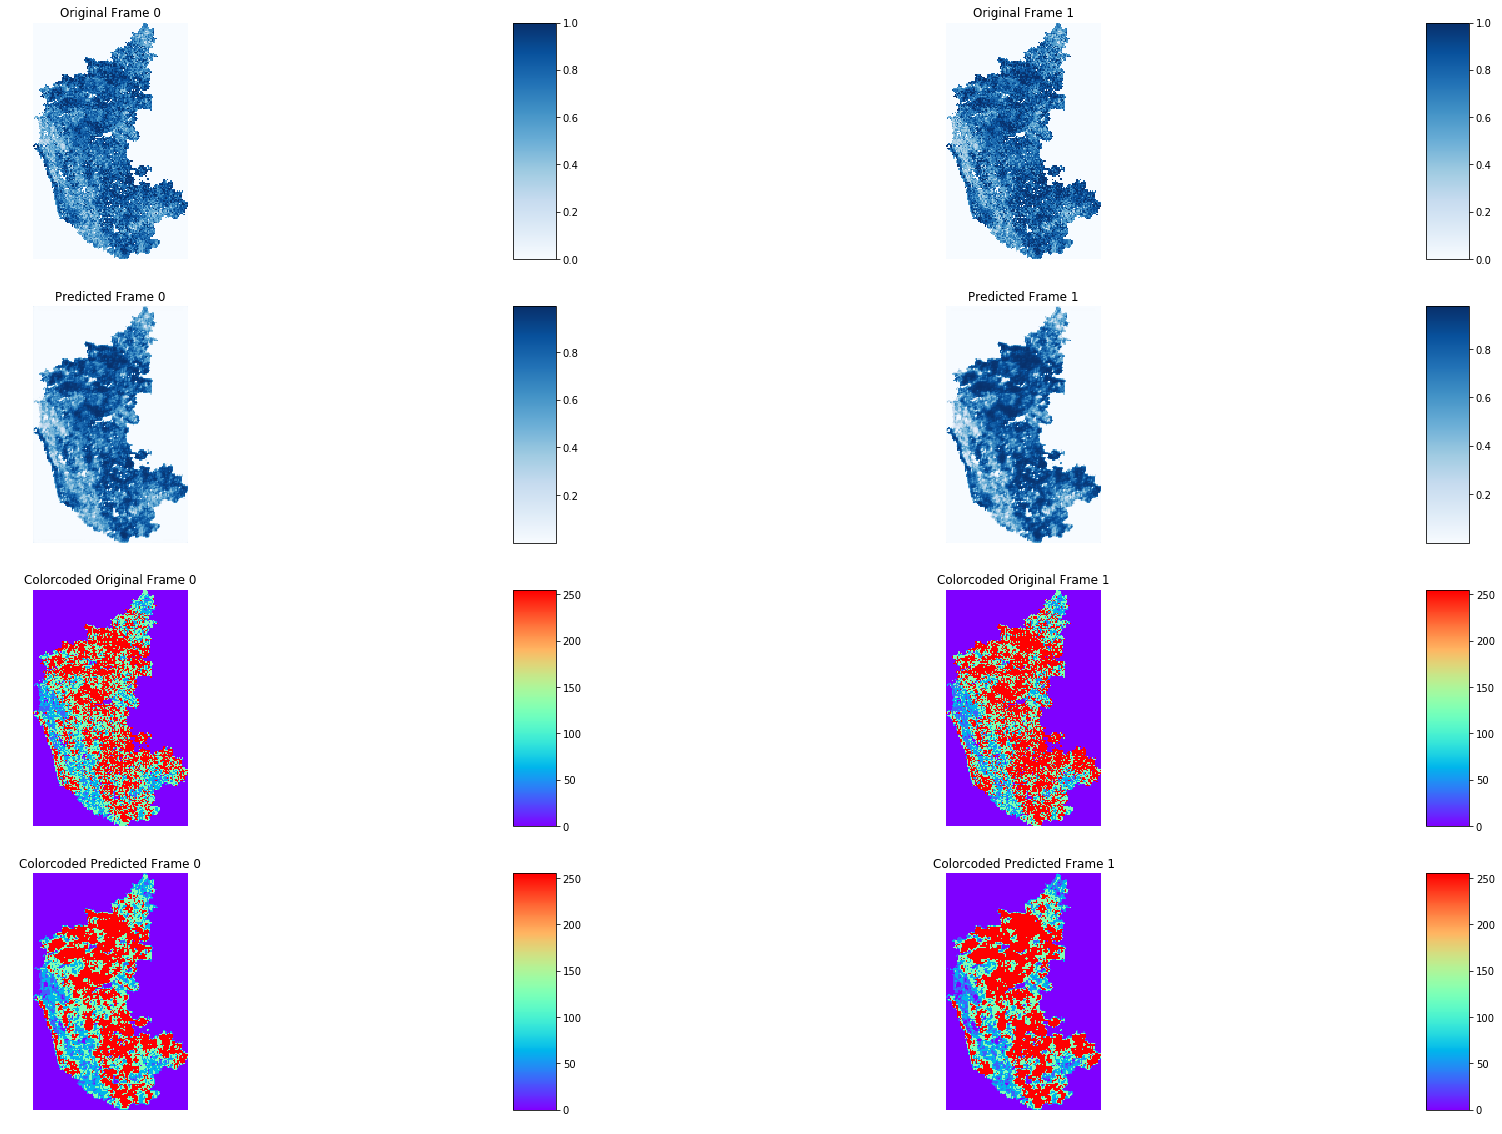

In [ ]:
# Predict a new set of 10 frames.
ix = np.random.choice(range(len(x_test)), size=1)[0]
example = x_test[ix]
frames = example[:2, ...]
original_frames = example[1:3, ...]
for _ in range(2):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)
#print(frames.shape)
# Construct a figure for the original and new frames.
fig, axes = plt.subplots(4, 2, figsize=(30, 20))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    pos = ax.imshow(np.squeeze(original_frames[idx]), cmap="Blues")
    ax.set_title(f"Original Frame {idx}")
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    fig.colorbar(pos, ax = ax, cax =cax)
    ax.axis("off")

# Plot the new frames.
new_frames = frames[2:, ...]
for idx, ax in enumerate(axes[1]):
    pos =ax.imshow(np.squeeze(new_frames[idx]), cmap="Blues")
    ax.set_title(f"Predicted Frame {idx}")
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    fig.colorbar(pos, ax = ax, cax =cax)
    ax.axis("off")

for idx, ax in enumerate(axes[2]):
    orig = unscale(np.squeeze(original_frames[idx]),vhi_test_label[ix][idx])
    colorcoded = colorcoding(orig)
    pos= ax.imshow(colorcoded, cmap='rainbow')
    ax.set_title(f"Colorcoded Original Frame {idx}")
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    fig.colorbar(pos, ax = ax, cax =cax)
    ax.axis("off")

new_frames = frames[2:, ...]
for idx, ax in enumerate(axes[3]):
    pred = unscale(np.squeeze(new_frames[idx]), vhi_test_label[ix][idx-2])
    colorcoded = colorcoding(pred)
    pos = ax.imshow(colorcoded, cmap='rainbow')
    ax.set_title(f"Colorcoded Predicted Frame {idx}")
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    fig.colorbar(pos, ax = ax, cax =cax)
    ax.axis("off")

# Display the figure.
plt.show()

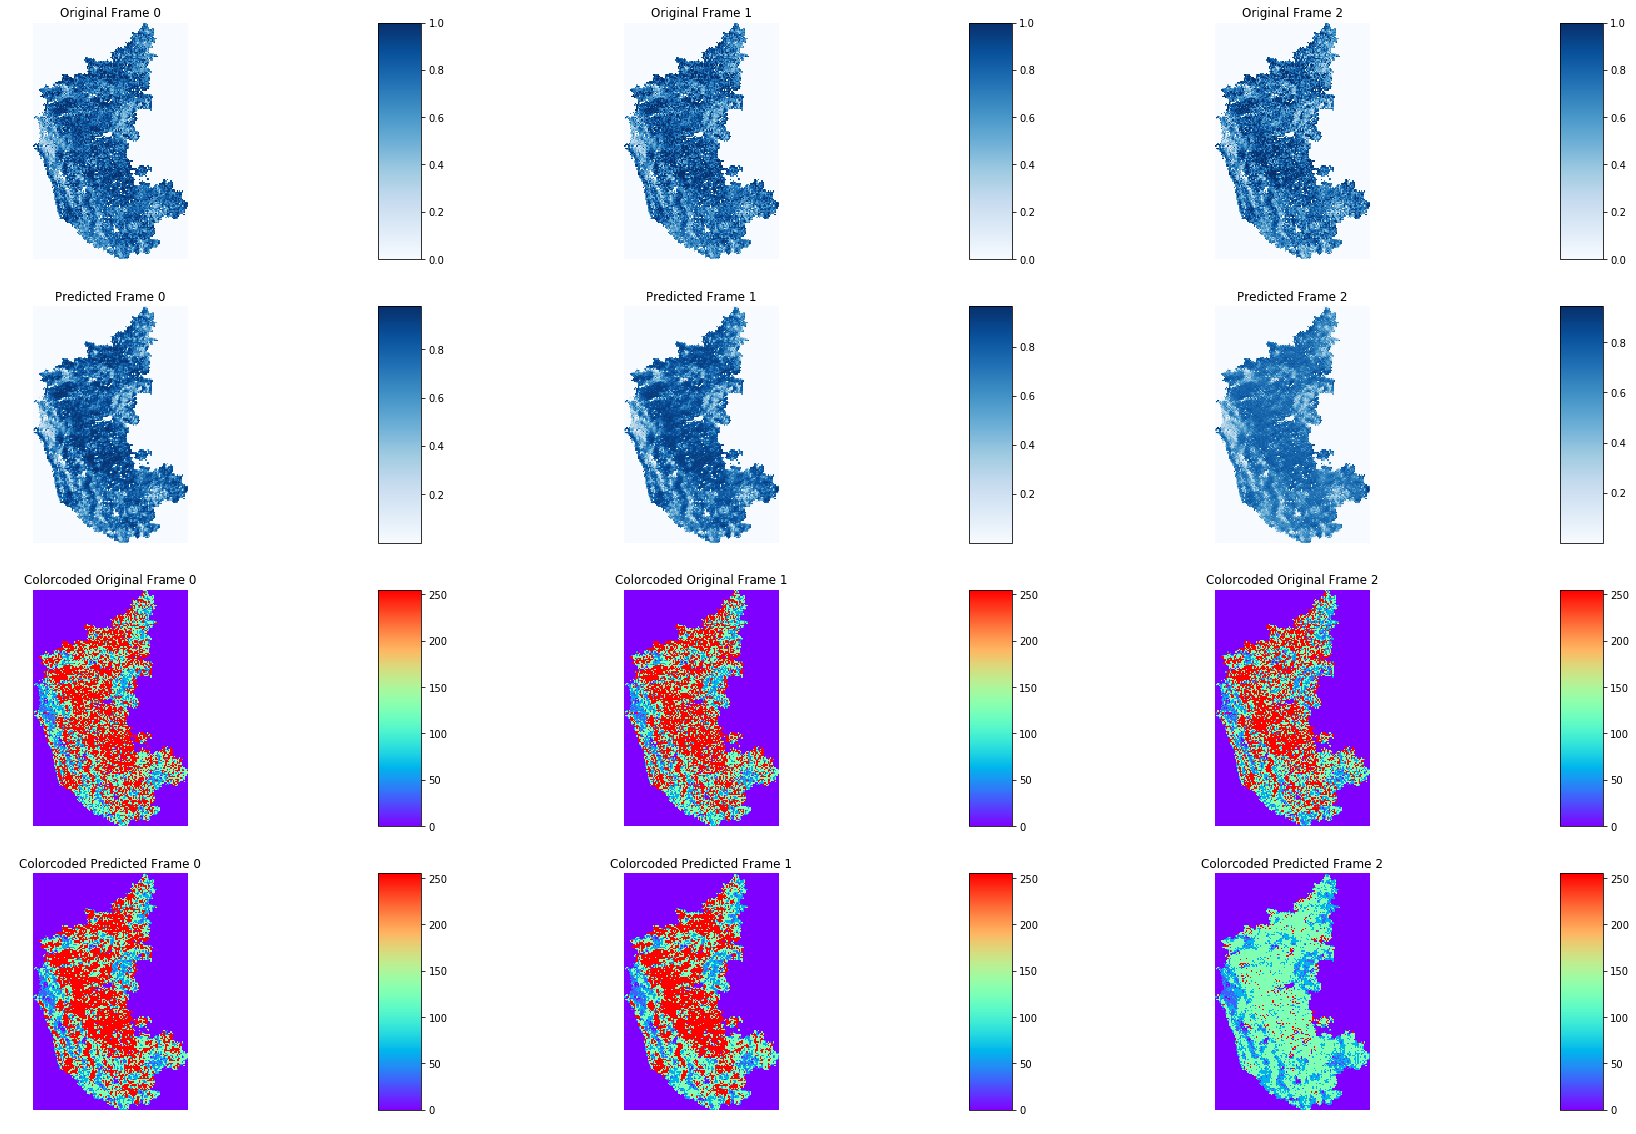

In [ ]:
# Predict a new set of 10 frames.
ix = np.random.choice(range(len(x_test)), size=1)[0]
example = x_test[ix]
frames = example[:3, ...]
original_frames = example[1:, ...]
for _ in range(3):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)
#print(frames.shape)
# Construct a figure for the original and new frames.
fig, axes = plt.subplots(4, 3, figsize=(30, 20))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    pos = ax.imshow(np.squeeze(original_frames[idx]), cmap="Blues")
    ax.set_title(f"Original Frame {idx}")
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    fig.colorbar(pos, ax = ax, cax =cax)
    ax.axis("off")

# Plot the new frames.
new_frames = frames[3:, ...]
for idx, ax in enumerate(axes[1]):
    pos =ax.imshow(np.squeeze(new_frames[idx]), cmap="Blues")
    ax.set_title(f"Predicted Frame {idx}")
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    fig.colorbar(pos, ax = ax, cax =cax)
    ax.axis("off")

for idx, ax in enumerate(axes[2]):
    orig = unscale(np.squeeze(original_frames[idx]),vhi_test_label[ix][idx])
    colorcoded = colorcoding(orig)
    pos= ax.imshow(colorcoded, cmap='rainbow')
    ax.set_title(f"Colorcoded Original Frame {idx}")
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    fig.colorbar(pos, ax = ax, cax =cax)
    ax.axis("off")

new_frames = frames[3:, ...]
for idx, ax in enumerate(axes[3]):
    pred = unscale(np.squeeze(new_frames[idx]), vhi_test_label[ix][idx-3])
    colorcoded = colorcoding(pred)
    pos = ax.imshow(colorcoded, cmap='rainbow')
    ax.set_title(f"Colorcoded Predicted Frame {idx}")
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    fig.colorbar(pos, ax = ax, cax =cax)
    ax.axis("off")

# Display the figure.
plt.show()

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
data = x_test
label = y_test
predicted =[]
true = []
R2 =[]
res = []
MSE =[]
for i in range(len(data)):
    #for j in range(4):
    framed = data[i][0]
    y_real = label[i][0].reshape(192,128)
    test = framed.reshape(1,1,192,128,1)
    pred = model.predict(test)
    pred = pred.reshape(192,128)
    r2 = r2_score(y_real,pred)
    residual = mae(y_real,pred)
    err = mse(y_real,pred)
    MSE.append(err)
    res.append(residual)
    predicted.append(pred)
    true.append(y_real)
    R2.append(r2)

np.save("F:\Jyoti Shukla -MS\codes\Saved models and history AVHRR_total/R2_score_convLSTM+conv3D_total_model_6.1.npy", R2)
np.save("F:\Jyoti Shukla -MS\codes\Saved models and history AVHRR_total/MAE_for_ConvLSTM+ Conv3D_total_model_6.1.npy",res)
np.save("F:\Jyoti Shukla -MS\codes\Saved models and history AVHRR_total/MSE_for_ConvLSTM+Conv3D_total_model_6.1.npy",MSE)
np.save("F:\Jyoti Shukla -MS\codes\Saved models and history AVHRR_total/Predicted_outputs_ConvLSTM+Conv3D_total_model_6.1.npy", predicted)


# r2 = r2_score(y_real, pred)
print(len(R2))
print('r2 score for test data on model is: \n', R2)

48
r2 score for test data on model is: 
 [0.8716768107832534, 0.8667632275850765, 0.8659850942145655, 0.8661515356449834, 0.8634800504401426, 0.867735594560034, 0.8691913549769402, 0.8594655744510837, 0.8518845363002457, 0.849731216319202, 0.8490300488749206, 0.8469332221261372, 0.8419496335011247, 0.8362313044340633, 0.8342970566851066, 0.8285212672299811, 0.8244953322371513, 0.8245932297069507, 0.827304127823501, 0.821971790760297, 0.827112344713101, 0.8206533473919162, 0.8082222913771413, 0.7986407190904503, 0.7797349200393788, 0.7693807960568024, 0.7488080041039851, 0.7808020022991815, 0.7920927286092656, 0.7970833733138226, 0.8089448928927683, 0.8231039994756406, 0.8333068735696331, 0.8431724672599292, 0.8487806276009358, 0.852178260498522, 0.8497167105929215, 0.8340842496009901, 0.8446067400614233, 0.8407370068690947, 0.8343837771259579, 0.8292234949901331, 0.8247185921408539, 0.8191315712484115, 0.8168204465566514, 0.8102194921867236, 0.802092836806132, 0.8012715490577031]


## ConvLSTM with conv2D

In [ ]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=8,
    kernel_size=(2, 2),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
#x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)
x = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(2, 2),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
#x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(2, 2),
    padding="same",
    return_sequences=False,
    activation="sigmoid",
)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
#x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(
    filters=8,
    kernel_size=(2, 2),
    padding="same",
    activation="relu",
)(x)
# x = layers.BatchNormalization()(x)
# #x = layers.UpSampling2D((2, 2))(x)
# x = layers.Conv2D(
#     filters=32,
#     kernel_size=(3, 3),
#     padding="same",
#     activation="relu",
# )(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(
    filters=1,
    kernel_size=(2, 2),
    padding="same",
    activation="relu",
)(x)
# x = layers.Conv3D(
#     filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
# )(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss='mae', optimizer='sgd',metrics=[tf.keras.metrics.mse]
)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, 192, 128, 1 0         
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, None, 192, 128, 8) 1184      
_________________________________________________________________
batch_normalization_4 (Batch (None, None, 192, 128, 8) 32        
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, None, 192, 128, 16 6208      
_________________________________________________________________
batch_normalization_5 (Batch (None, None, 192, 128, 16 64        
_________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)  (None, 192, 128, 64)      82176     
_________________________________________________________________
batch_normalization_6 (Batch (None, 192, 128, 64)      256 

In [ ]:
inp.shape

TensorShape([None, None, 192, 128, 1])

In [ ]:
y_train.shape

(2065, 192, 128, 1)

In [ ]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 50
batch_size = 2

# Fit the model to the training data.
history= model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr],
)
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/convlstm+conv2d_history_total.npy", history.history)
model.save("F:\Jyoti Shukla -MS\codes\Different model output total/convlstm+conv2d_model_total.h5")

Epoch 1/50
1033/1033 [==============================] - 591s 561ms/step - loss: 0.1210 - mean_squared_error: 0.0529 - val_loss: 0.0536 - val_mean_squared_error: 0.0122
Epoch 2/50
1033/1033 [==============================] - 567s 549ms/step - loss: 0.0623 - mean_squared_error: 0.0139 - val_loss: 0.0479 - val_mean_squared_error: 0.0089
Epoch 3/50
1033/1033 [==============================] - 567s 549ms/step - loss: 0.0529 - mean_squared_error: 0.0099 - val_loss: 0.0403 - val_mean_squared_error: 0.0056
Epoch 4/50
1033/1033 [==============================] - 568s 549ms/step - loss: 0.0472 - mean_squared_error: 0.0076 - val_loss: 0.0408 - val_mean_squared_error: 0.0053
Epoch 5/50
1033/1033 [==============================] - 567s 549ms/step - loss: 0.0418 - mean_squared_error: 0.0060 - val_loss: 0.0372 - val_mean_squared_error: 0.0044
Epoch 6/50
1033/1033 [==============================] - 568s 550ms/step - loss: 0.0391 - mean_squared_error: 0.0053 - val_loss: 0.0429 - val_mean_squared_error:

In [ ]:
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/convlstm+conv2d_history.npy", history.history)
history.history.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error', 'lr'])

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import History
from tensorflow import keras
import tensorflow_addons as tfa
model_conv2 = load_model("F:\Jyoti Shukla -MS\codes\Different model output total/convlstm+conv2d_model_total.h5")
history_conv2 = np.load("F:\Jyoti Shukla -MS\codes\Different model output total/convlstm+conv2d_history_total.npy",allow_pickle=True).item()
history_conv2.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error', 'lr'])

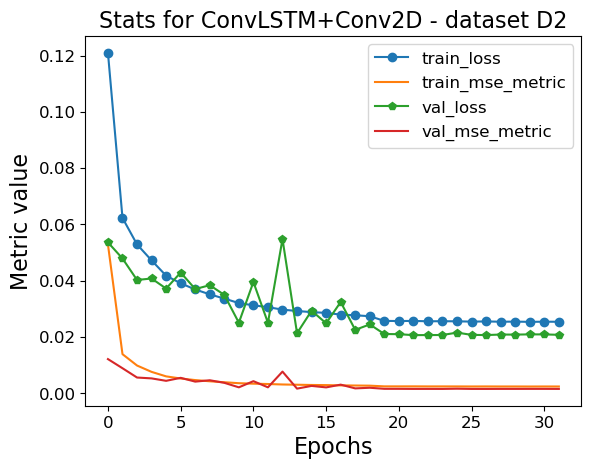

In [ ]:
# Results of updated model6

plt.plot(history_conv2['loss'],'-o')
plt.plot(history_conv2['mean_squared_error'])
plt.plot(history_conv2['val_loss'],'-p')
plt.plot(history_conv2['val_mean_squared_error'])

plt.title('Stats for ConvLSTM+Conv2D - dataset D2', fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('Metric value', fontsize = 16)
plt.legend(['train_loss','train_mse_metric','val_loss','val_mse_metric'], fontsize = 12)
plt.show()

In [ ]:
x_test[1].shape

(4, 190, 124, 1)

In [ ]:
y_test[40].shape

(190, 124, 1)

0.24533083342326856


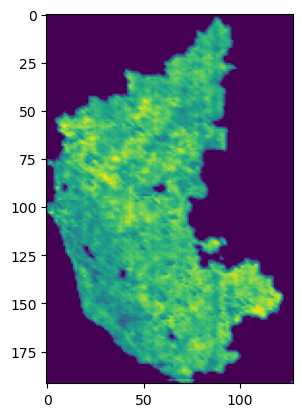

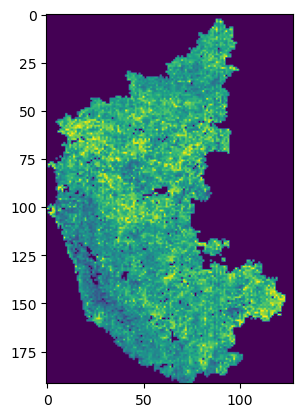

In [ ]:
model = model_conv2
from sklearn.metrics import r2_score
framed = x_test[4][1:2,...]
pred = model.predict(np.expand_dims(framed, axis=0))
y_real = y_test[4].reshape(192,128)
pred = pred.reshape(192,128)
r2 = r2_score(y_real,pred)
print(r2)
plt.imshow(pred.reshape(192,128))
plt.figure()
plt.imshow(y_real.reshape(192,128))

Text(0.5, 0.98, 'ConvLSTM+Conv2D Outputs')

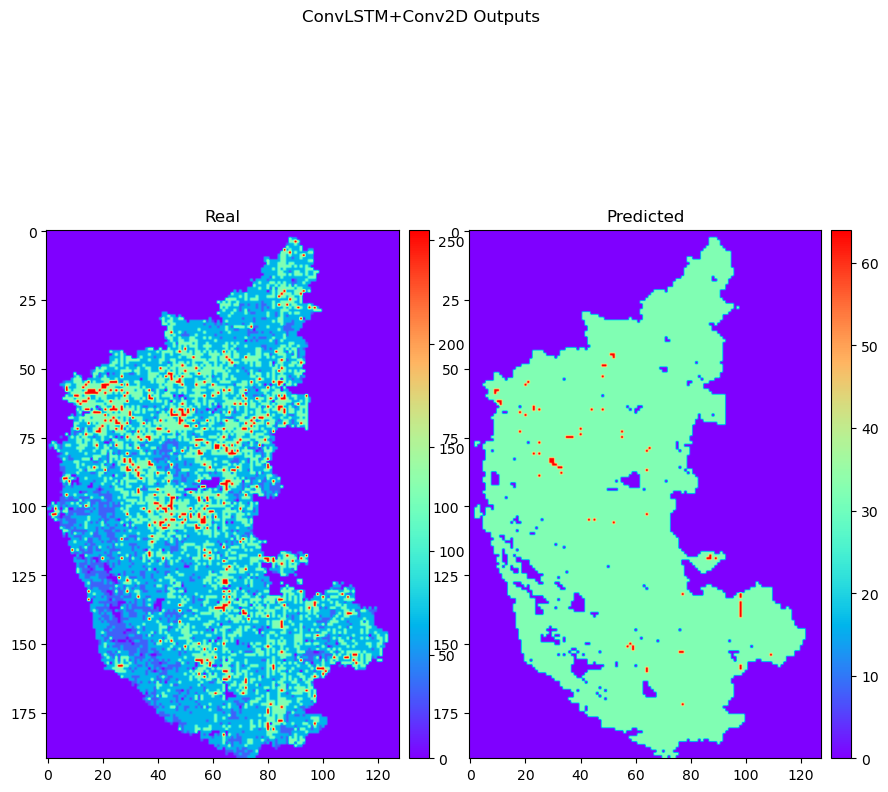

In [ ]:
unscale_pred = unscale(pred,vhi_test_label[4])
unscale_real = unscale(y_real,vhi_test_label[4])
colorcoded_pred = colorcoding(unscale_pred)
colorcoded_real = colorcoding(unscale_real)
images = [colorcoded_real, colorcoded_pred]
titles =["Real","Predicted"]
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
for i in range(len(images)):
    pos = ax[i].imshow(images[i].reshape(192,128), cmap="rainbow")
    #ax.set_title(f"Original Frame {idx}")
    cax = fig.add_axes([ax[i].get_position().x1+0.01,ax[i].get_position().y0,0.02,ax[i].get_position().height])
    fig.colorbar(pos, ax = ax[i], cax =cax)
    ax[i].set_title(titles[i])
    #ax.axis("off")
fig.suptitle("ConvLSTM+Conv2D Outputs")

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
data = x_test
label = y_test
predicted_mod =[]
true = []
R2_mod =[]
res_mod = []
mse_mod =[]
for i in range(len(data)):
    #for j in range(4):
    framed = data[i][0]
    y_real = label[i].reshape(192,128)
    test = framed.reshape(1,1,192,128,1)
    pred = model.predict(test)
    pred = pred.reshape(192,128)
    r2 = r2_score(y_real,pred)
    residual = mae(y_real,pred)
    res_mod.append(residual)
    err = mse(y_real,pred)
    mse_mod.append(err)
    predicted_mod.append(pred)
    true.append(y_real)
    R2_mod.append(r2)

np.save("F:\Jyoti Shukla -MS\codes\Different model output total/R2_score_convLSTM+conv2D_total.npy", R2_mod)
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/MAE_for_ConvLSTM+ Conv2D_total.npy",res_mod)
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/MSE_for_ConvLSTM+Conv2D_total.npy",mse_mod)
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/Predicted_outputs_ConvLSTM+Conv2D_total.npy", predicted_mod)
# r2 = r2_score(y_real, pred)
print(len(R2_mod))
print('r2 score for test data on model is: \n', R2_mod)

48
r2 score for test data on model is: 
 [0.25933967024270266, 0.24856325522494305, 0.24705529807338336, 0.23592813130222334, 0.2398621844427095, 0.2251039450114602, 0.21332387919921103, 0.20450299235250607, 0.1863618427706863, 0.19236058347972057, 0.18657389340318908, 0.1729363881020809, 0.16987818742629693, 0.16056347242169305, 0.16471578842769688, 0.19238273590634938, 0.192994955102248, 0.20529294642836685, 0.205618265044845, 0.1837412001874667, 0.18181236206087464, 0.15294777121909986, 0.14209598932823217, 0.12656049324355154, 0.19515719360531752, 0.22428844747834117, 0.2529964535407513, 0.31529869568825686, 0.305535033759222, 0.33102529850208373, 0.36103342602111577, 0.3733676976097384, 0.36071185667793587, 0.32854569854407356, 0.2376530822931205, 0.23127286534786157, 0.18506425762362486, 0.15762353882453523, 0.1935450572699352, 0.15554728521702837, 0.17155650886561224, 0.2003025904162127, 0.19876741988516655, 0.1925524808946429, 0.20067096943513912, 0.24907703662754208, 0.3238702

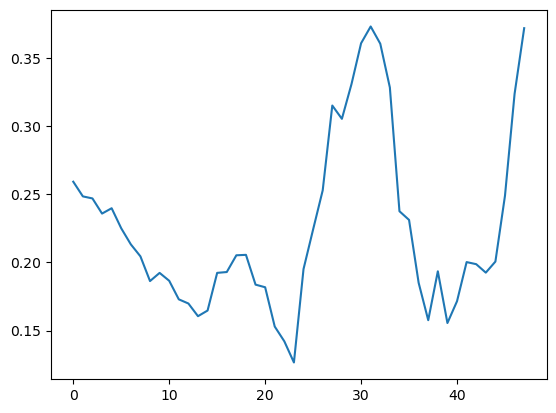

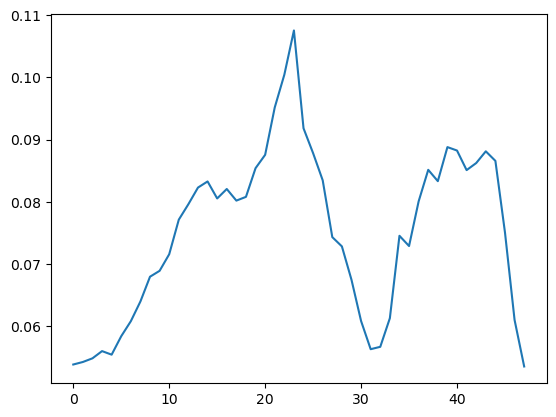

In [ ]:
plt.plot(R2_mod)
plt.show()
plt.plot(mse_mod)

In [ ]:
np.mean(R2_mod), np.max(R2_mod), np.mean(res_mod), np.mean(mse_mod)

(0.2251687425293399, 0.3733676976097384, 0.17931853, 0.07518724)

## *Conv3D*

In [ ]:
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense, LSTM
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from plotly.offline import iplot, init_notebook_mode
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta
import plotly.graph_objs as go
from matplotlib.pyplot import cm
from keras.models import Model
import numpy as np
import keras
import h5py


In [ ]:
## input layer
input_layer = Input(shape=(None, *x_train.shape[2:]))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu',padding="same")(input_layer)
conv_layer2 = Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu',padding="same")(conv_layer1)

## add max pooling to obtain the most imformatic features
#pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

conv_layer3 = Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu',padding="same")(conv_layer2)
conv_layer4 = Conv3D(filters=1, kernel_size=(3, 3, 3), activation='sigmoid',padding="same")(conv_layer3)
# pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)
# out= LSTM(4)(conv_layer4)

# ## perform batch normalization on the convolution outputs before feeding it to MLP architecture
# pooling_layer2 = BatchNormalization()(pooling_layer2)
# flatten_layer = Flatten()(pooling_layer2)

# ## create an MLP architecture with dense layers : 4096 -> 512 -> 10
# ## add dropouts to avoid overfitting / perform regularization
# dense_layer1 = Dense(units=2048, activation='relu')(flatten_layer)
# dense_layer1 = Dropout(0.4)(dense_layer1)
# dense_layer2 = Dense(units=512, activation='relu')(dense_layer1)
# dense_layer2 = Dropout(0.4)(dense_layer2)
# output_layer = Dense(units=10, activation='softmax')(dense_layer2)

## define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=conv_layer4)
model.compile(loss='mse', optimizer='sgd', metrics=[tf.keras.metrics.mse])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 192, 128, 1 0         
_________________________________________________________________
conv3d (Conv3D)              (None, None, 192, 128, 8) 224       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, None, 192, 128, 8) 1736      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, None, 192, 128, 16 3472      
_________________________________________________________________
conv3d_3 (Conv3D)            (None, None, 192, 128, 1) 433       
Total params: 5,865
Trainable params: 5,865
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 50
batch_size = 1

# Fit the model to the training data.
history= model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr],
)
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/conv3D_history_total.npy", history.history)
model.save("F:\Jyoti Shukla -MS\codes\Different model output total/conv3D_model_total.h5")

Epoch 1/50
2065/2065 [==============================] - 95s 46ms/step - loss: 0.0392 - mean_squared_error: 0.0392 - val_loss: 0.0169 - val_mean_squared_error: 0.0169
Epoch 2/50
2065/2065 [==============================] - 91s 44ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 3/50
2065/2065 [==============================] - 88s 43ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0124 - val_mean_squared_error: 0.0124
Epoch 4/50
2065/2065 [==============================] - 88s 42ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 5/50
2065/2065 [==============================] - 88s 42ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 6/50
2065/2065 [==============================] - 88s 42ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoc

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import History
from tensorflow import keras
import tensorflow_addons as tfa
model_conv3 = load_model("F:\Jyoti Shukla -MS\codes\Different model output total/conv3D_model_total.h5")
history_conv3 = np.load("F:\Jyoti Shukla -MS\codes\Different model output total/conv3D_history_total.npy",allow_pickle=True).item()
history_conv3.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error', 'lr'])

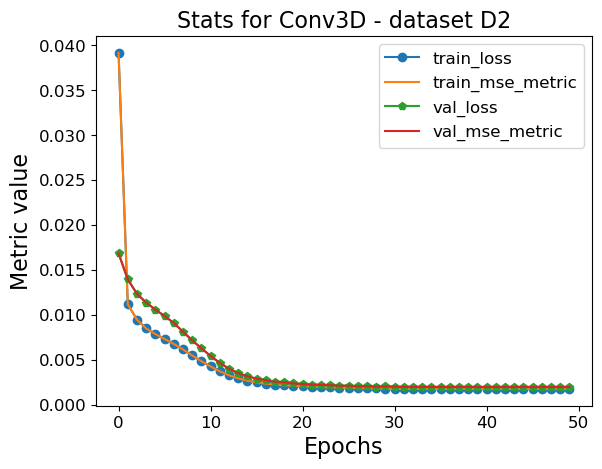

In [ ]:
# Results of updated model6

plt.plot(history_conv3['loss'],'-o')
plt.plot(history_conv3['mean_squared_error'])
plt.plot(history_conv3['val_loss'],'-p')
plt.plot(history_conv3['val_mean_squared_error'])

plt.title('Stats for Conv3D - dataset D2', fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('Metric value', fontsize = 16)
plt.legend(['train_loss','train_mse_metric','val_loss','val_mse_metric'], fontsize = 12)
plt.show()

mse 0.058754135
r2 score is: 0.3109098284558939 

discrete values, predicted and real respectively: 0.39888275 0.6221


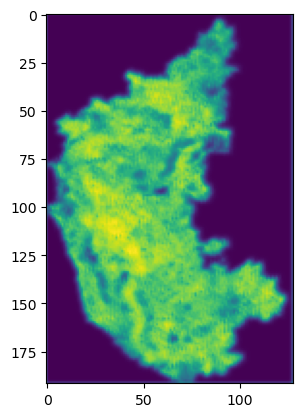

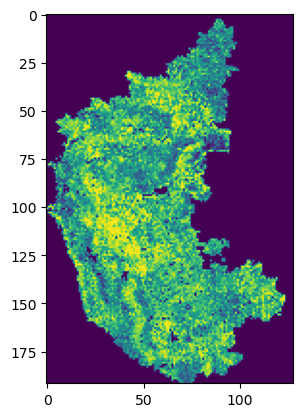

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
framed = x_test[36][:1,...]
pred = model_conv3.predict(np.expand_dims(framed, axis=0))
y_real = y_test[36][0]
pred = pred.reshape(192,128,1)
plt.imshow(pred.reshape(192,128))
plt.figure()
plt.imshow(y_real.reshape(192,128))
r2 = r2_score(y_real.reshape(192,128),pred.reshape(192,128))
mse = mse(y_real.reshape(192,128),pred.reshape(192,128))
print("mse",mse)
print("r2 score is:", r2,"\n")
pred = pred.reshape(192,128)
y_real = y_real.reshape(192,128)
print("discrete values, predicted and real respectively:",(pred.reshape(192,128))[50][30],(y_real.reshape(192,128))[50][30])

Text(0.5, 0.98, 'Conv3D Outputs')

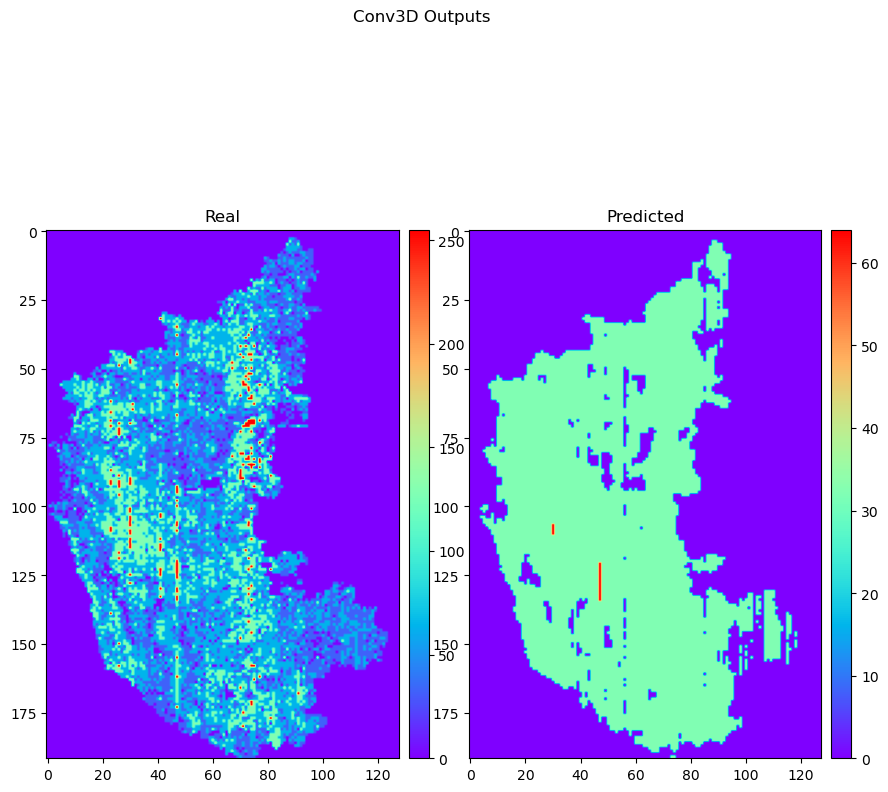

In [ ]:
unscale_pred = unscale(pred,vhi_test_label[36][0])
unscale_real = unscale(y_real,vhi_test_label[36][0])
colorcoded_pred = colorcoding(unscale_pred)
colorcoded_real = colorcoding(unscale_real)
images = [colorcoded_real, colorcoded_pred]
titles =["Real","Predicted"]
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
for i in range(len(images)):
    pos = ax[i].imshow(images[i].reshape(192,128), cmap="rainbow")
    #ax.set_title(f"Original Frame {idx}")
    cax = fig.add_axes([ax[i].get_position().x1+0.01,ax[i].get_position().y0,0.02,ax[i].get_position().height])
    fig.colorbar(pos, ax = ax[i], cax =cax)
    ax[i].set_title(titles[i])
    #ax.axis("off")
fig.suptitle("Conv3D Outputs")

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
data = x_test
label = y_test
predicted =[]
true = []
R2 =[]
res = []
MSE =[]
for i in range(len(data)):
    #for j in range(4):
    framed = data[i][0]
    y_real = label[i][0].reshape(192,128)
    test = framed.reshape(1,1,192,128,1)
    pred = model_conv3.predict(test)
    pred = pred.reshape(192,128)
    r2 = r2_score(y_real,pred)
    residual = mae(y_real,pred)
    err = mse(y_real,pred)
    MSE.append(err)
    res.append(residual)
    predicted.append(pred)
    true.append(y_real)
    R2.append(r2)

np.save("F:\Jyoti Shukla -MS\codes\Different model output total/R2_score_Conv3D_total.npy", R2)
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/MAE_for_Conv3D_total.npy",res)
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/MSE_for_Conv3D_total.npy",MSE)
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/Predicted_outputs_Conv3D_total.npy", predicted)


# r2 = r2_score(y_real, pred)
print(len(R2))
print('r2 score for test data on model is: \n', R2)

48
r2 score for test data on model is: 
 [0.35498625222199603, 0.34531743287918926, 0.34711524090208457, 0.3463919302346682, 0.34642257066548815, 0.3439239116280574, 0.3379440545373796, 0.34701950480996735, 0.33010444873549605, 0.32464779629223517, 0.3140821888912434, 0.30986297148385633, 0.31082626462805246, 0.2953496941988568, 0.27297282503186615, 0.27755354320506215, 0.2740830544382459, 0.2730893057688679, 0.2789704454787216, 0.26652357570319396, 0.2717608933292127, 0.2612388323243149, 0.24471834116231214, 0.2451319201946545, 0.22346013019518768, 0.2226200502340628, 0.20234686829230814, 0.27446948490241063, 0.2481428807112365, 0.2560181858061594, 0.2840557020420746, 0.29512601402246774, 0.30654309115486333, 0.325826004814281, 0.33872123804513604, 0.3262167517648401, 0.3109098284558939, 0.26458249712945553, 0.32366337898577774, 0.27964396558190785, 0.26922012127291595, 0.2730898924401216, 0.26991815276014103, 0.2642033859643775, 0.27135883938717154, 0.25891484544842025, 0.25183076396

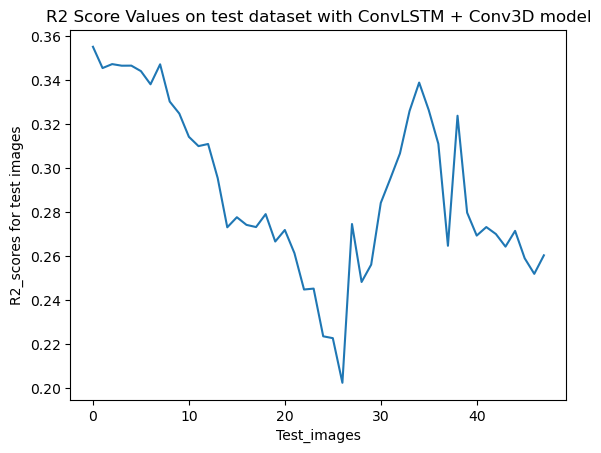

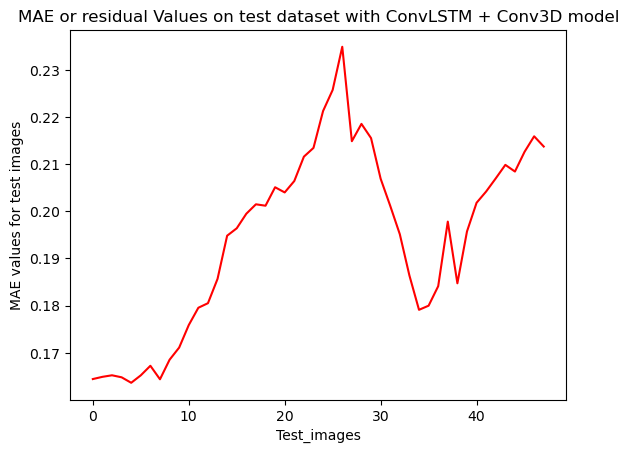

Text(0.5, 1.0, 'MSE Values on test dataset with ConvLSTM + Conv3D model')

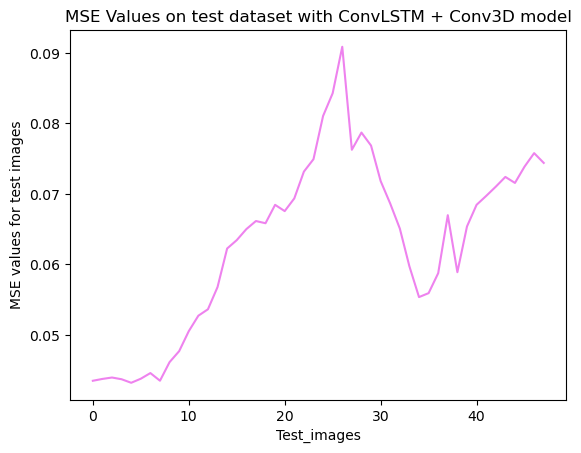

In [ ]:
R2_3d = np.load("F:\Jyoti Shukla -MS\codes\Different model output total/R2_score_Conv3D_total.npy")
res_3d = np.load("F:\Jyoti Shukla -MS\codes\Different model output total/MAE_for_Conv3D_total.npy")
MSE_3d = np.load("F:\Jyoti Shukla -MS\codes\Different model output total/MSE_for_Conv3D_total.npy")
plt.plot(R2_3d)
plt.xlabel("Test_images")
plt.ylabel("R2_scores for test images")
plt.title("R2 Score Values on test dataset with ConvLSTM + Conv3D model")
plt.show()
plt.plot(res_3d,color='red')
plt.xlabel("Test_images")
plt.ylabel("MAE values for test images")
plt.title("MAE or residual Values on test dataset with ConvLSTM + Conv3D model")
plt.show()
plt.plot(MSE_3d, 'violet')
plt.xlabel("Test_images")
plt.ylabel("MSE values for test images")
plt.title("MSE Values on test dataset with ConvLSTM + Conv3D model")

In [ ]:
np.mean(R2_3d), np.max(R2_3d), np.mean(MSE_3d), np.mean(res_3d)

(0.29002434336409205, 0.35498625222199603, 0.06302811, 0.1943881)

## *1D- CNN model*

In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
#raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
# choose a number of time steps
n_steps = 2
# split into samples
traindata = np.reshape(train_dataset, (2069,24576))
trainlabel =  np.reshape(train_labels,(2069,24576) )
X, y = split_sequence(traindata, n_steps)
X.shape, y.shape

((2067, 2, 24576), (2067, 24576))

In [ ]:
n_steps = 2
testdata = np.reshape(test_dataset, (52,24576))
testlabel =  np.reshape(test_labels,(52,24576) )
XTest, YTest = split_sequence(testdata, n_steps)
print(XTest.shape, YTest.shape)
n_features = XTest.shape[2]
XTest = XTest.reshape((XTest.shape[0], XTest.shape[1], n_features))

(50, 2, 24576) (50, 24576)


In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
# define model
n_features = X.shape[2]
X = X.reshape((X.shape[0], X.shape[1], n_features))
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2, padding ='same'))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(24576))
model.compile(optimizer='adam', loss='mae', metrics=['mse'])
# fit model
history= model.fit(X, y, epochs=40, validation_data=(XTest, YTest), verbose=2)
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/1dcnn_total_2.npy", history.history)
model.save("F:\Jyoti Shukla -MS\codes\Different model output total/1dcnn_model_total_2.h5")
# demonstrate prediction

Epoch 1/40
65/65 - 1s - loss: 0.1073 - mse: 0.0327 - val_loss: 0.0781 - val_mse: 0.0180
Epoch 2/40
65/65 - 1s - loss: 0.0786 - mse: 0.0183 - val_loss: 0.0751 - val_mse: 0.0173
Epoch 3/40
65/65 - 1s - loss: 0.0759 - mse: 0.0173 - val_loss: 0.0709 - val_mse: 0.0158
Epoch 4/40
65/65 - 1s - loss: 0.0724 - mse: 0.0158 - val_loss: 0.0676 - val_mse: 0.0148
Epoch 5/40
65/65 - 1s - loss: 0.0689 - mse: 0.0146 - val_loss: 0.0658 - val_mse: 0.0143
Epoch 6/40
65/65 - 1s - loss: 0.0684 - mse: 0.0145 - val_loss: 0.0625 - val_mse: 0.0125
Epoch 7/40
65/65 - 1s - loss: 0.0664 - mse: 0.0137 - val_loss: 0.0609 - val_mse: 0.0117
Epoch 8/40
65/65 - 1s - loss: 0.0647 - mse: 0.0131 - val_loss: 0.0571 - val_mse: 0.0103
Epoch 9/40
65/65 - 1s - loss: 0.0638 - mse: 0.0128 - val_loss: 0.0590 - val_mse: 0.0109
Epoch 10/40
65/65 - 1s - loss: 0.0634 - mse: 0.0126 - val_loss: 0.0562 - val_mse: 0.0096
Epoch 11/40
65/65 - 1s - loss: 0.0631 - mse: 0.0125 - val_loss: 0.0552 - val_mse: 0.0093
Epoch 12/40
65/65 - 1s - loss:

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import History
from tensorflow import keras
import tensorflow_addons as tfa
model_1dcnn = load_model("F:\Jyoti Shukla -MS\codes\Different model output total/1dcnn_model_total_2.h5")
history_1dcnn = np.load("F:\Jyoti Shukla -MS\codes\Different model output total/1dcnn_total_2.npy",allow_pickle=True).item()
history_1dcnn.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

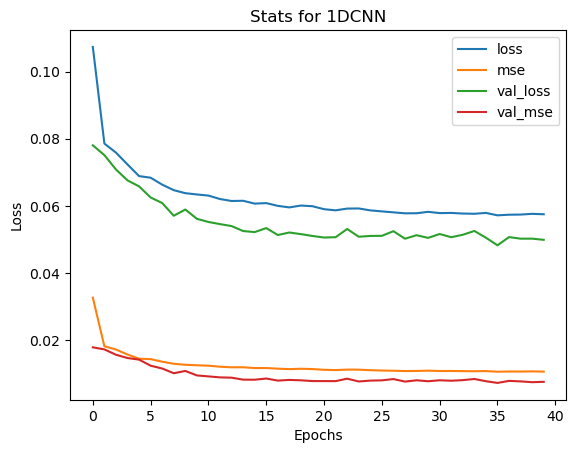

In [ ]:
# Results of updated model6

plt.plot(history_1dcnn['loss'])
plt.plot(history_1dcnn['mse'])
plt.plot(history_1dcnn['val_loss'])
plt.plot(history_1dcnn['val_mse'])

plt.title('Stats for 1DCNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss','mse','val_loss','val_mse'])
plt.show()

In [ ]:
framed = XTest[4]
(np.expand_dims(framed, axis=0)).shape

(1, 4, 24576)

(1, 24576)
0.8601385971020674


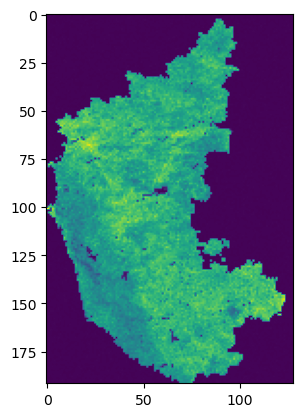

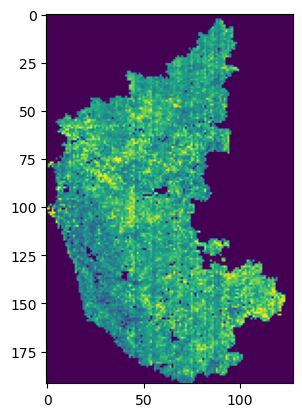

In [ ]:
model = model_1dcnn
from sklearn.metrics import r2_score
framed = XTest[4]
pred = model.predict(np.expand_dims(framed, axis=0))
print(pred.shape)
y_real = YTest[4].reshape(192,128)
pred = pred.reshape(192,128)
r2 = r2_score(y_real,pred)
print(r2)
plt.imshow(pred.reshape(192,128))
plt.figure()
plt.imshow(y_real.reshape(192,128))

In [ ]:
# data_test = load_real_samples("F:\Jyoti Shukla -MS\karnataka dataset\Padded_paired_unscaled_test_total_AVHRR_data_1981_2022.npz")
# test_data, test_label = data_test[0], data_test[1]
#print(test_data.shape, test_label.shape)
print(test_data_rfvhi.shape)
# vhi_train, vhi_train_label, n_steps = split_sequence(train_data, 4)
vhi_test, vhi_test_label, n_steps = split_sequence(rf_vhi_test, test_data_rfvhi, 2)
# print("Training Dataset Shapes: " + str(vhi_train.shape) + ", " + str(vhi_train_label.shape))
print("Validation Dataset Shapes: " + str(vhi_test.shape) + ", " + str(vhi_test_label.shape))

Text(0.5, 0.98, '1D- CNN Outputs')

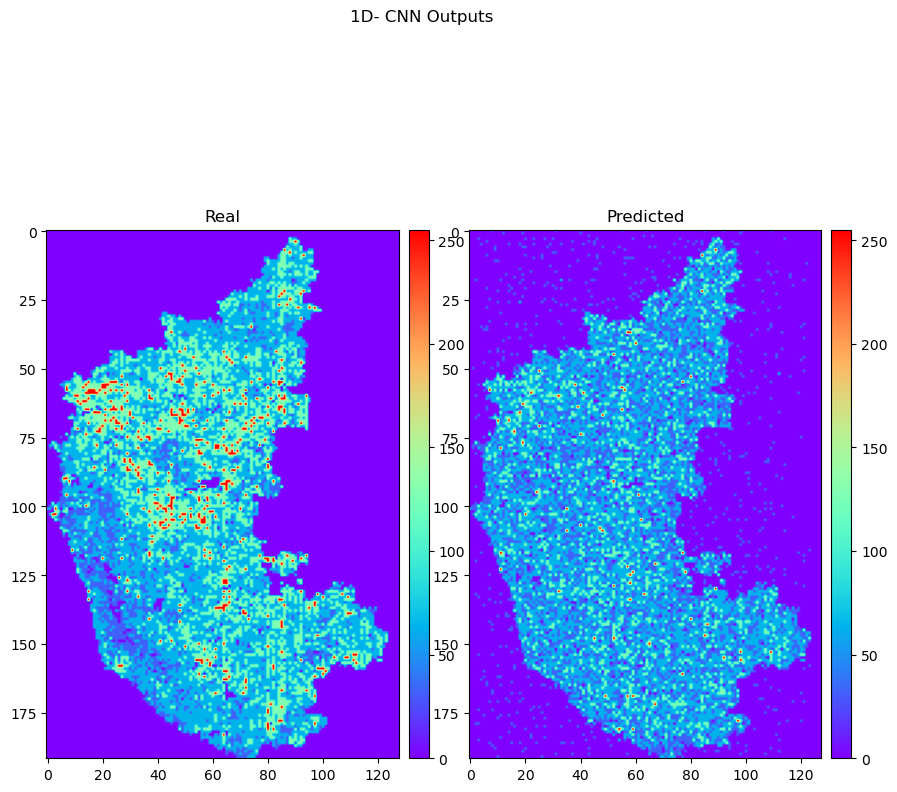

In [ ]:
pred = pred.reshape(192,128,1)
y_real = y_real.reshape(192,128,1)
unscale_pred = unscale(pred,vhi_test_label[4])
unscale_real = unscale(y_real,vhi_test_label[4])
colorcoded_pred = colorcoding(unscale_pred)
colorcoded_real = colorcoding(unscale_real)
images = [colorcoded_real, colorcoded_pred]
titles =["Real","Predicted"]
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
for i in range(len(images)):
    pos = ax[i].imshow(images[i].reshape(192,128), cmap="rainbow")
    #ax.set_title(f"Original Frame {idx}")
    cax = fig.add_axes([ax[i].get_position().x1+0.01,ax[i].get_position().y0,0.02,ax[i].get_position().height])
    fig.colorbar(pos, ax = ax[i], cax =cax)
    ax[i].set_title(titles[i])
    #ax.axis("off")
fig.suptitle("1D- CNN Outputs")

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
data = XTest
label = YTest
predicted_mod =[]
true = []
R2_mod =[]
res_mod = []
mse_mod =[]
for i in range(len(data)):
    #for j in range(4):
    framed = data[i]
    y_real = label[i].reshape(192,128)
    # test = framed.reshape(1,1,192,128,1)
    pred = model.predict(np.expand_dims(framed, axis=0))
    pred = pred.reshape(192,128)
    r2 = r2_score(y_real,pred)
    residual = mae(y_real,pred)
    res_mod.append(residual)
    err = mse(y_real,pred)
    mse_mod.append(err)
    predicted_mod.append(pred)
    true.append(y_real)
    R2_mod.append(r2)

np.save("F:\Jyoti Shukla -MS\codes\Different model output total/R2_score_1DCNN_total.npy", R2_mod)
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/MAE_for_1DCNN_total.npy",res_mod)
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/MSE_for_1DCNN_total.npy",mse_mod)
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/Predicted_outputs_1DCNN_total.npy", predicted_mod)
# r2 = r2_score(y_real, pred)
print(len(R2_mod))
print('r2 score for test data on model is: \n', R2_mod)

50
r2 score for test data on model is: 
 [0.8639514887534382, 0.8653911661081319, 0.8639436610201636, 0.8596473957665788, 0.8601385971020674, 0.8652087095543906, 0.8668944640597369, 0.869750516574201, 0.8786310513298571, 0.8909214039899318, 0.8963932150399379, 0.9030336772988092, 0.9080536610032903, 0.910780897170502, 0.9079860390667776, 0.9063729974593627, 0.9049410235221648, 0.9017691264034396, 0.8954663685611852, 0.898625118983718, 0.9010057627634267, 0.9046654083679377, 0.9091561648927907, 0.9117424672175256, 0.9099505031937547, 0.9071931370419706, 0.9018189798244393, 0.9042615699437396, 0.9009033689229466, 0.8900370054773968, 0.8853815134719987, 0.8843951341616519, 0.8826257358851022, 0.8777024103203237, 0.8755061179870421, 0.8729122131989404, 0.8788651560568771, 0.8710603428624668, 0.8759001665776986, 0.880673095804148, 0.8827184895396651, 0.8870060417891565, 0.894591071130955, 0.8967767697184226, 0.8993989952297865, 0.904351374647496, 0.9042948332891847, 0.89577316485443, 0.8879

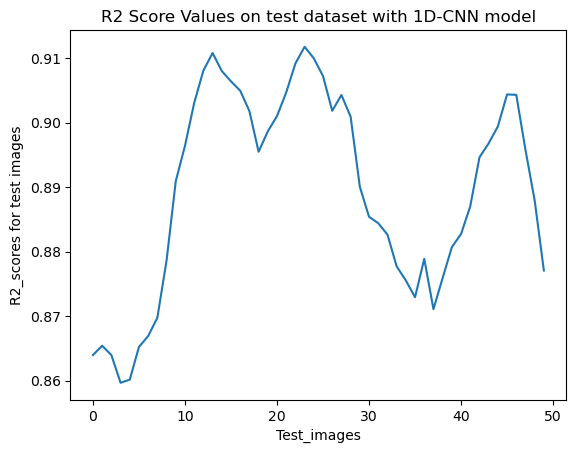

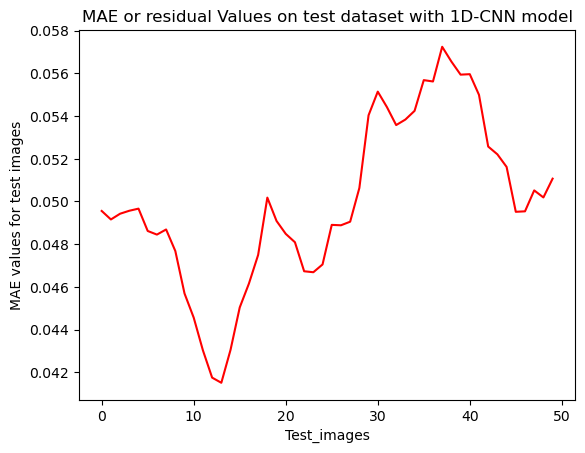

Text(0.5, 1.0, 'MSE Values on test dataset with 1D-CNN model')

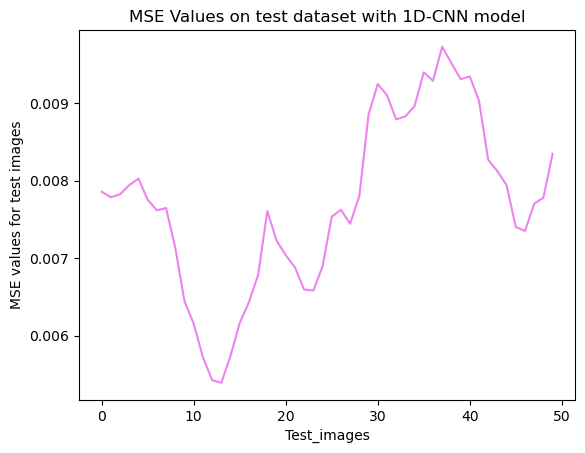

In [ ]:
R2 = np.load("F:\Jyoti Shukla -MS\codes\Different model output total/R2_score_1DCNN_total.npy")
res = np.load("F:\Jyoti Shukla -MS\codes\Different model output total/MAE_for_1DCNN_total.npy")
MSE = np.load("F:\Jyoti Shukla -MS\codes\Different model output total/MSE_for_1DCNN_total.npy")
plt.plot(R2)
plt.xlabel("Test_images")
plt.ylabel("R2_scores for test images")
plt.title("R2 Score Values on test dataset with 1D-CNN model")
plt.show()
plt.plot(res,color='red')
plt.xlabel("Test_images")
plt.ylabel("MAE values for test images")
plt.title("MAE or residual Values on test dataset with 1D-CNN model")
plt.show()
plt.plot(MSE, 'violet')
plt.xlabel("Test_images")
plt.ylabel("MSE values for test images")
plt.title("MSE Values on test dataset with 1D-CNN model")

In [ ]:
np.mean(R2), np.max(R2), np.mean(MSE), np.mean(res)

(0.889470792880887, 0.9117424672175256, 0.0077063525, 0.04994414)

# BiLSTM

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
#raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
# choose a number of time steps
n_steps = 2
# split into samples
traindata = np.reshape(train_dataset, (2069,24576))
trainlabel =  np.reshape(train_labels,(2069,24576) )
X, y = split_sequence(traindata, n_steps)
print(X.shape, y.shape)
n_steps = 2
testdata = np.reshape(test_dataset, (52,24576))
testlabel =  np.reshape(test_labels,(52,24576) )
XTest, YTest = split_sequence(testdata, n_steps)
print(XTest.shape, YTest.shape)
n_features = XTest.shape[2]
XTest = XTest.reshape((XTest.shape[0], XTest.shape[1], n_features))

(2067, 2, 24576) (2067, 24576)
(50, 2, 24576) (50, 24576)


In [ ]:
n_features = X.shape[2]
X = X.reshape((X.shape[0], X.shape[1], n_features))
model = Sequential()
    # Input layer
model.add(Bidirectional(LSTM(units = 50, return_sequences=True), input_shape=(n_steps, n_features)))
model.add(Bidirectional(LSTM(units = 1200, return_sequences=True), input_shape=(n_steps, n_features)))
model.add(Bidirectional(LSTM(units = 200)))
model.add(Dense(n_features))
#Compile model
model.compile(optimizer='adam',loss='mae',metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 2, 100)            9850800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 2, 2400)           12489600  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 400)               4161600   
_________________________________________________________________
dense (Dense)                (None, 24576)             9854976   
Total params: 36,356,976
Trainable params: 36,356,976
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# early_stop = keras.callbacks.EarlyStopping(monitor = ‘val_loss’,
#                                                patience = 10)
history = model.fit(X, y, epochs=30, validation_data=(XTest, YTest), verbose=2)
np.save(r"F:\Jyoti Shukla -MS\codes\Different model output total/BiLSTM_history_total.npy", history.history)
model.save(r"F:\Jyoti Shukla -MS\codes\Different model output total/BiLSTM_total.h5")

Epoch 1/30
65/65 - 13s - loss: 0.1475 - mse: 0.0669 - val_loss: 0.0879 - val_mse: 0.0217
Epoch 2/30
65/65 - 2s - loss: 0.0877 - mse: 0.0221 - val_loss: 0.0949 - val_mse: 0.0255
Epoch 3/30
65/65 - 2s - loss: 0.0854 - mse: 0.0214 - val_loss: 0.0930 - val_mse: 0.0249
Epoch 4/30
65/65 - 2s - loss: 0.0847 - mse: 0.0213 - val_loss: 0.0909 - val_mse: 0.0239
Epoch 5/30
65/65 - 2s - loss: 0.0852 - mse: 0.0216 - val_loss: 0.0847 - val_mse: 0.0211
Epoch 6/30
65/65 - 2s - loss: 0.0845 - mse: 0.0213 - val_loss: 0.0902 - val_mse: 0.0238
Epoch 7/30
65/65 - 2s - loss: 0.0842 - mse: 0.0212 - val_loss: 0.0886 - val_mse: 0.0232
Epoch 8/30
65/65 - 2s - loss: 0.0841 - mse: 0.0213 - val_loss: 0.0886 - val_mse: 0.0232
Epoch 9/30
65/65 - 2s - loss: 0.0839 - mse: 0.0212 - val_loss: 0.0896 - val_mse: 0.0237
Epoch 10/30
65/65 - 2s - loss: 0.0840 - mse: 0.0213 - val_loss: 0.0945 - val_mse: 0.0261
Epoch 11/30
65/65 - 2s - loss: 0.0838 - mse: 0.0212 - val_loss: 0.0892 - val_mse: 0.0235
Epoch 12/30
65/65 - 2s - loss

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import History
from tensorflow import keras
import tensorflow_addons as tfa
model_BiLSTM = load_model(r"F:\Jyoti Shukla -MS\codes\Different model output total/BiLSTM_total.h5")
history_BiLSTM = np.load(r"F:\Jyoti Shukla -MS\codes\Different model output total/BiLSTM_history_total.npy",allow_pickle=True).item()
history_BiLSTM.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

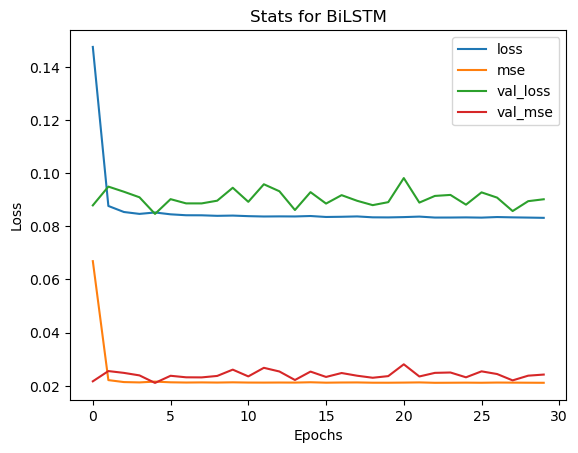

In [ ]:
# Results of updated model6

plt.plot(history_BiLSTM['loss'])
plt.plot(history_BiLSTM['mse'])
plt.plot(history_BiLSTM['val_loss'])
plt.plot(history_BiLSTM['val_mse'])

plt.title('Stats for BiLSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss','mse','val_loss','val_mse'])
plt.show()

In [ ]:
framed = XTest[4]
(np.expand_dims(framed, axis=0)).shape

(1, 2, 24576)

(1, 24576)
0.7928495424172144


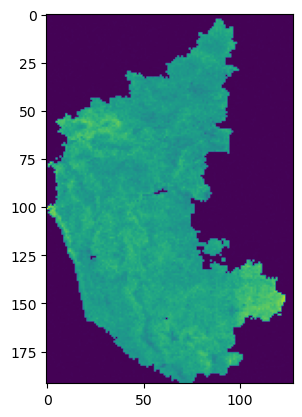

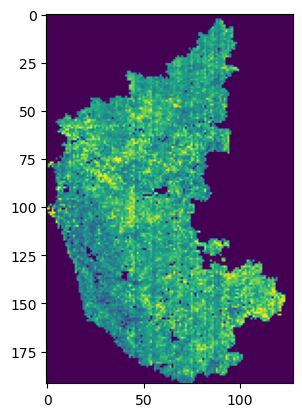

In [ ]:
model = model_BiLSTM
from sklearn.metrics import r2_score
framed = XTest[4]
pred = model.predict(np.expand_dims(framed, axis=0))
print(pred.shape)
y_real = YTest[4].reshape(192,128)
pred = pred.reshape(192,128)
r2 = r2_score(y_real,pred)
print(r2)
plt.imshow(pred.reshape(192,128))
plt.figure()
plt.imshow(y_real.reshape(192,128))

In [ ]:
# data_test = load_real_samples("F:\Jyoti Shukla -MS\karnataka dataset\Padded_paired_unscaled_test_total_AVHRR_data_1981_2022.npz")
# test_data, test_label = data_test[0], data_test[1]
#print(test_data.shape, test_label.shape)
print(test_data_rfvhi.shape)
# vhi_train, vhi_train_label, n_steps = split_sequence(train_data, 4)
vhi_test, vhi_test_label, n_steps = split_sequence(rf_vhi_test, test_data_rfvhi, 2)
# print("Training Dataset Shapes: " + str(vhi_train.shape) + ", " + str(vhi_train_label.shape))
print("Validation Dataset Shapes: " + str(vhi_test.shape) + ", " + str(vhi_test_label.shape))

In [ ]:
pred = pred.reshape(192,128,1)
y_real = y_real.reshape(192,128,1)
unscale_pred = unscale(pred,vhi_test_label[4])
unscale_real = unscale(y_real,vhi_test_label[4])
colorcoded_pred = colorcoding(unscale_pred)
colorcoded_real = colorcoding(unscale_real)
images = [colorcoded_real, colorcoded_pred]
titles =["Real","Predicted"]
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
for i in range(len(images)):
    pos = ax[i].imshow(images[i].reshape(192,128), cmap="rainbow")
    #ax.set_title(f"Original Frame {idx}")
    cax = fig.add_axes([ax[i].get_position().x1+0.01,ax[i].get_position().y0,0.02,ax[i].get_position().height])
    fig.colorbar(pos, ax = ax[i], cax =cax)
    ax[i].set_title(titles[i])
    #ax.axis("off")
fig.suptitle("1D- CNN Outputs")

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
data = XTest
label = YTest
predicted_mod =[]
true = []
R2_mod =[]
res_mod = []
mse_mod =[]
for i in range(len(data)):
    #for j in range(4):
    framed = data[i]
    y_real = label[i].reshape(192,128)
    # test = framed.reshape(1,1,192,128,1)
    pred = model.predict(np.expand_dims(framed, axis=0))
    pred = pred.reshape(192,128)
    r2 = r2_score(y_real,pred)
    residual = mae(y_real,pred)
    res_mod.append(residual)
    err = mse(y_real,pred)
    mse_mod.append(err)
    predicted_mod.append(pred)
    true.append(y_real)
    R2_mod.append(r2)

np.save("F:\Jyoti Shukla -MS\codes\Different model output total/R2_score_bilstm_total.npy", R2_mod)
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/MAE_for_bilstm_total.npy",res_mod)
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/MSE_for_bilstm_total.npy",mse_mod)
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/Predicted_outputs_bilstm_total.npy", predicted_mod)
# r2 = r2_score(y_real, pred)
print(len(R2_mod))
print('r2 score for test data on model is: \n', R2_mod)

50
r2 score for test data on model is: 
 [0.798433521520458, 0.7967113246047337, 0.7951447152980193, 0.7895916646644904, 0.7948384934010488, 0.8077830325680874, 0.8076451522506328, 0.8068704874375022, 0.8049577270880721, 0.8089640911663578, 0.8073505962863371, 0.8038082189159044, 0.8020519673476147, 0.803073415131334, 0.8002297938667423, 0.8050903121060944, 0.8062545254047324, 0.806000748151931, 0.8015166525695774, 0.8041717360853049, 0.800482502381458, 0.7912498009394084, 0.785003125097713, 0.7687433672652513, 0.7569184383597176, 0.7397939202859656, 0.7665471412177742, 0.7684839517167603, 0.7705180136996024, 0.7710093089227457, 0.7660868483587597, 0.7621819371265659, 0.7579164115157053, 0.7499736307451863, 0.7485155832908913, 0.7509299581000619, 0.7725101686797718, 0.7697422559125886, 0.7836524658524999, 0.7915790295610589, 0.7913114668724459, 0.7920856946592889, 0.7927262362731942, 0.7943372480923945, 0.7941361472356274, 0.7896809150241353, 0.7870376083777897, 0.8003797150111972, 0.8

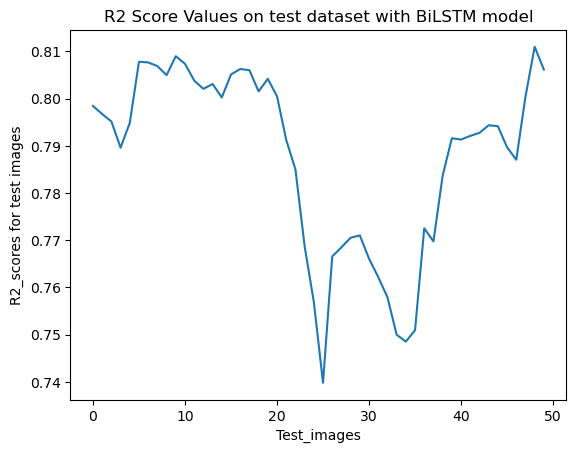

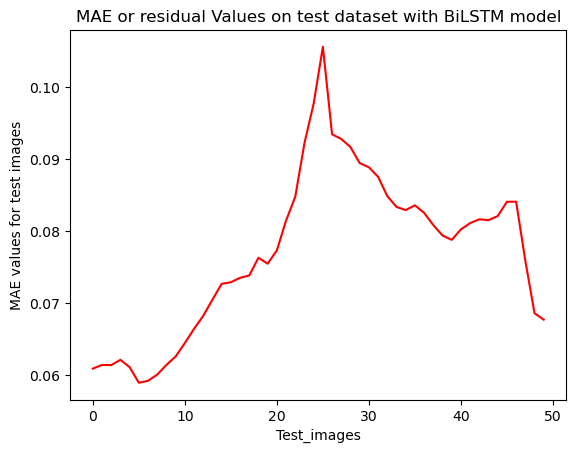

Text(0.5, 1.0, 'MSE Values on test dataset with BiLSTM model')

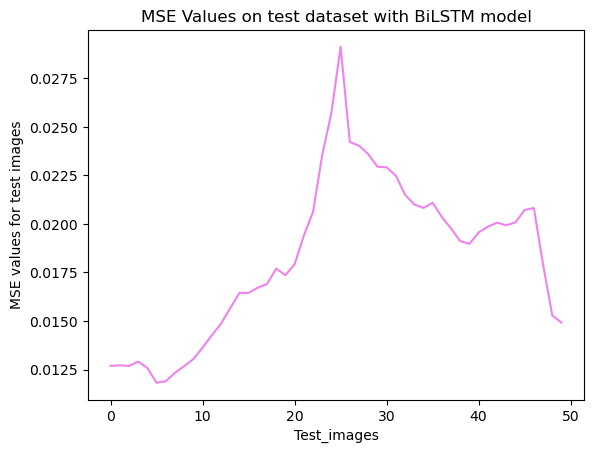

In [ ]:
R2 = np.load("F:\Jyoti Shukla -MS\codes\Different model output total/R2_score_bilstm_total.npy")
res = np.load("F:\Jyoti Shukla -MS\codes\Different model output total/MAE_for_bilstm_total.npy")
MSE = np.load("F:\Jyoti Shukla -MS\codes\Different model output total/MSE_for_bilstm_total.npy")
plt.plot(R2)
plt.xlabel("Test_images")
plt.ylabel("R2_scores for test images")
plt.title("R2 Score Values on test dataset with BiLSTM model")
plt.show()
plt.plot(res,color='red')
plt.xlabel("Test_images")
plt.ylabel("MAE values for test images")
plt.title("MAE or residual Values on test dataset with BiLSTM model")
plt.show()
plt.plot(MSE, 'violet')
plt.xlabel("Test_images")
plt.ylabel("MSE values for test images")
plt.title("MSE Values on test dataset with BiLSTM model")

In [ ]:
np.mean(R2), np.max(R2), np.mean(MSE), np.mean(res)

(0.7876220367490023, 0.8109577084823527, 0.018274335, 0.076980785)

# CNN - BiLSTM

In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, GlobalMaxPool1D,Input
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [ ]:
X.shape

(2067, 2, 24576)

In [ ]:
# input_dim = int(X_train_sequence.shape[2])
n_features = X.shape[2]
input_dim=n_features
output_dim = y.shape[1]
n_samples = len(X)
n_steps=2
X = X.reshape((X.shape[0], X.shape[1], n_features))
X_train_series_sub = X.reshape((X.shape[0], n_steps, n_features, 1))
# X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
X_test_series_sub = XTest.reshape((XTest.shape[0], n_steps, n_features, 1))
print('Train set shape', X_train_series_sub.shape)
print('Test set shape', X_test_series_sub.shape)
# print('Validation set shape', X_valid_series_sub.shape)


Train set shape (2067, 2, 24576, 1)
Test set shape (50, 2, 24576, 1)


In [ ]:
model = Sequential()
    #model.add(TimeDistributed(Conv1D(filters=256, kernel_size=4, activation='tanh')))
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation='tanh'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
# model.add(TimeDistributed(Conv1D(filters=1024, kernel_size=2, activation='tanh')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2, padding= 'same')))
model.add(TimeDistributed(GlobalMaxPool1D()))
model.add(Bidirectional(LSTM(64, return_sequences=True, activation = 'tanh')))
model.add(TimeDistributed(Dense(24576, activation = 'sigmoid')))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mae', optimizer=opt, metrics=['mse'])
model.summary()
# fit model


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, None, 24575, 128)  384       
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 12288, 128)  0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 128)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 24576)       3170304   
Total params: 3,269,504
Trainable params: 3,269,504
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history= model.fit(X_train_series_sub, y, epochs=10, validation_data=(X_test_series_sub, YTest), verbose=2)
np.save(r"F:\Jyoti Shukla -MS\codes\Different model output total/cnnbilstm_total.npy", history.history)
model.save(r"F:\Jyoti Shukla -MS\codes\Different model output total/cnnbilstm_model_total.h5")

Epoch 1/10


ResourceExhaustedError:  OOM when allocating tensor with shape[64,12288,1,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_1/time_distributed_4/max_pooling1d/MaxPool-0-2-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_11451]

Function call stack:
train_function


# Different convlstm models

In [ ]:
from tensorflow.keras.layers import AveragePooling3D, BatchNormalization
def fn_get_model_convLSTM_2():

    model = Sequential()

    model.add(ConvLSTM2D(filters=32, kernel_size=(2, 2),padding='same',
                         input_shape=(None, 256, 256, 1),
                         return_sequences=True,
                         go_backwards=True,
                         activation='tanh', recurrent_activation='hard_sigmoid',
                         kernel_initializer='glorot_uniform', unit_forget_bias=True,
                         dropout=0.3, recurrent_dropout=0.2
                         ))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2),padding='same'))
    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3),padding='same',
                         return_sequences=True,
                         go_backwards=True,
                         activation='tanh', recurrent_activation='hard_sigmoid',
                         kernel_initializer='glorot_uniform', unit_forget_bias=True,
                         dropout=0.3, recurrent_dropout=0.2
                         ))
    model.add(BatchNormalization())
    model.add(UpSampling3D(size=(2,2,2)))
    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3),padding='same',
                         return_sequences=False,
                         go_backwards=True,
                         activation='tanh', recurrent_activation='hard_sigmoid',
                         kernel_initializer='glorot_uniform', unit_forget_bias=True,
                         dropout=0.3, recurrent_dropout=0.2
                         ))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=1, kernel_size=(1, 1),padding='same',
                   activation='sigmoid',
                   data_format='channels_last'))
    model.compile(loss='mean_squared_error', optimizer='sgd',metrics=[tf.keras.metrics.CosineSimilarity(axis=1)])
    print(model.summary())
    return model

In [ ]:
model = fn_get_model_convLSTM_2()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_20 (ConvLSTM2D)  (None, None, 256, 256, 3  17024    
                             2)                                  
                                                                 
 batch_normalization_20 (Bat  (None, None, 256, 256, 3  128      
 chNormalization)            2)                                  
                                                                 
 max_pooling3d_6 (MaxPooling  (None, None, 128, 128, 3  0        
 3D)                         2)                                  
                                                                 
 conv_lstm2d_21 (ConvLSTM2D)  (None, None, 128, 128, 8  11552    
                             )                                   
                                                                 
 batch_normalization_21 (Bat  (None, None, 128, 128, 8

In [ ]:
from keras.callbacks import History
def fn_run_model(model, X, y, X_val, y_val, batch_size=8, nb_epoch=15,verbose=2,is_graph=False):
    history = History()
    history = model.fit(X, y, batch_size=batch_size,
                        epochs=nb_epoch,verbose=verbose, validation_data=(X_val, y_val))
    if is_graph:
        fig, ax1 = plt.subplots(1,1)
        ax1.plot(history.history["val_loss"])
        ax1.plot(history.history["loss"])

In [ ]:
#fn_run_model(model,x_train,y_train, x_test,y_test, batch_size=8, nb_epoch=10, verbose=2, is_graph=True)
model.fit(x_train,y_train, batch_size =8,epochs = 10,validation_data=(x_test, y_test))

Epoch 1/10
11/11 [==============================] - 38s 2s/step - loss: 0.1223 - cosine_similarity: 0.8073 - val_loss: 0.0575 - val_cosine_similarity: 0.9045
Epoch 2/10
11/11 [==============================] - 22s 2s/step - loss: 0.1188 - cosine_similarity: 0.8111 - val_loss: 0.0572 - val_cosine_similarity: 0.9045
Epoch 3/10
11/11 [==============================] - 22s 2s/step - loss: 0.1144 - cosine_similarity: 0.8156 - val_loss: 0.0570 - val_cosine_similarity: 0.9045
Epoch 4/10
11/11 [==============================] - 22s 2s/step - loss: 0.1113 - cosine_similarity: 0.8202 - val_loss: 0.0567 - val_cosine_similarity: 0.9045
Epoch 5/10
11/11 [==============================] - 22s 2s/step - loss: 0.1069 - cosine_similarity: 0.8253 - val_loss: 0.0565 - val_cosine_similarity: 0.9045
Epoch 6/10
11/11 [==============================] - 22s 2s/step - loss: 0.1024 - cosine_similarity: 0.8306 - val_loss: 0.0563 - val_cosine_similarity: 0.9045
Epoch 7/10
11/11 [==============================] - 

In [ ]:
pred = model.predict(x_test)

In [ ]:
from keras.layers.convolutional import UpSampling3D
from keras.layers.pooling import MaxPooling3D
def fn_get_model_convLSTM_tframe_4():

    model = Sequential()
    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3),
                         input_shape=(None, 256, 256, 1), padding='same', return_sequences=True,
                         activation='relu', recurrent_activation='hard_sigmoid',
                         kernel_initializer='glorot_uniform', unit_forget_bias=True,
                         dropout=0.3, recurrent_dropout=0.3))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size = (2,2,2), padding='same'))

    model.add(ConvLSTM2D(filters=8, kernel_size=(2, 2), padding='same', return_sequences=True,
                         activation='relu', recurrent_activation='hard_sigmoid',
                         kernel_initializer='glorot_uniform', unit_forget_bias=True,
                         dropout=0.4, recurrent_dropout=0.3))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size = (2,2,2), padding='same'))
    model.add(ConvLSTM2D(filters=8, kernel_size=(2,2), padding='same', return_sequences=True,
                         activation='relu', recurrent_activation='hard_sigmoid',
                         kernel_initializer='glorot_uniform', unit_forget_bias=True,
                         dropout=0.4, recurrent_dropout=0.3))
    model.add(BatchNormalization())
    model.add(UpSampling3D(size=(4,4,4)))

    model.add(ConvLSTM2D(filters=8, kernel_size=(2, 2), padding='same', return_sequences=False,
                         activation='relu', recurrent_activation='hard_sigmoid',
                         kernel_initializer='glorot_uniform', unit_forget_bias=True,
                         dropout=0.4, recurrent_dropout=0.3))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=1, kernel_size=(1, 1),
                   activation='sigmoid',
                   padding='same', data_format='channels_last'))

    ### !!! try go_backwards=True !!! ###
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=[tf.keras.metrics.CosineSimilarity(axis=1)])
    print(model.summary())

    return model

In [ ]:
model_1 = fn_get_model_convLSTM_tframe_4()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_27 (ConvLSTM2D)  (None, None, 256, 256, 1  9856     
                             6)                                  
                                                                 
 batch_normalization_27 (Bat  (None, None, 256, 256, 1  64       
 chNormalization)            6)                                  
                                                                 
 max_pooling3d_9 (MaxPooling  (None, None, 128, 128, 1  0        
 3D)                         6)                                  
                                                                 
 conv_lstm2d_28 (ConvLSTM2D)  (None, None, 128, 128, 8  3104     
                             )                                   
                                                                 
 batch_normalization_28 (Bat  (None, None, 128, 128, 8

In [ ]:
model_1.fit(x_train,y_train, batch_size =8,epochs = 10,validation_data=(x_test, y_test))

Epoch 1/10
11/11 [==============================] - 35s 2s/step - loss: 0.0931 - cosine_similarity: 0.8531 - val_loss: 0.0569 - val_cosine_similarity: 0.9045
Epoch 2/10
11/11 [==============================] - 14s 1s/step - loss: 0.0804 - cosine_similarity: 0.8669 - val_loss: 0.0560 - val_cosine_similarity: 0.9045
Epoch 3/10
11/11 [==============================] - 14s 1s/step - loss: 0.0725 - cosine_similarity: 0.8768 - val_loss: 0.0554 - val_cosine_similarity: 0.9045
Epoch 4/10
11/11 [==============================] - 14s 1s/step - loss: 0.0680 - cosine_similarity: 0.8832 - val_loss: 0.0548 - val_cosine_similarity: 0.9045
Epoch 5/10
11/11 [==============================] - 14s 1s/step - loss: 0.0661 - cosine_similarity: 0.8858 - val_loss: 0.0544 - val_cosine_similarity: 0.9045
Epoch 6/10
11/11 [==============================] - 14s 1s/step - loss: 0.0647 - cosine_similarity: 0.8878 - val_loss: 0.0541 - val_cosine_similarity: 0.9045
Epoch 7/10
11/11 [==============================] - 

In [ ]:
pred = model_1.predict(x_test)

array([[[0.44881225],
        [0.44881225],
        [0.44881225],
        ...,
        [0.44873774],
        [0.4487574 ],
        [0.45527452]],

       [[0.44881225],
        [0.44881225],
        [0.44881225],
        ...,
        [0.44873825],
        [0.44875762],
        [0.45527452]],

       [[0.44881254],
        [0.44881263],
        [0.44881207],
        ...,
        [0.448719  ],
        [0.44875133],
        [0.45527047]],

       ...,

       [[0.447951  ],
        [0.447951  ],
        [0.44795167],
        ...,
        [0.44940987],
        [0.44944102],
        [0.45519602]],

       [[0.44791177],
        [0.4479118 ],
        [0.44791254],
        ...,
        [0.44930193],
        [0.4494125 ],
        [0.45500648]],

       [[0.45174688],
        [0.45174694],
        [0.4517476 ],
        ...,
        [0.45258018],
        [0.45264295],
        [0.45723784]]], dtype=float32)

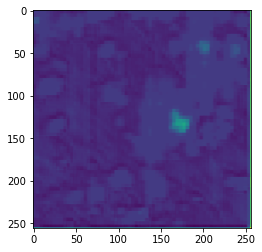

In [ ]:
plt.imshow(pred[12].reshape(256,256))
pred[12]

array([[[0.48982877],
        [0.42229389],
        [0.39844672],
        ...,
        [0.55214073],
        [0.47586127],
        [0.55111878]],

       [[0.48257639],
        [0.40776455],
        [0.3331807 ],
        ...,
        [0.55732828],
        [0.46868041],
        [0.57696428]],

       [[0.50013996],
        [0.39865   ],
        [0.32728507],
        ...,
        [0.62118773],
        [0.48862885],
        [0.51430524]],

       ...,

       [[0.45776756],
        [0.4078741 ],
        [0.42319239],
        ...,
        [0.1804819 ],
        [0.22802667],
        [0.36086264]],

       [[0.32292095],
        [0.28423992],
        [0.30027262],
        ...,
        [0.13355487],
        [0.21405866],
        [0.41041434]],

       [[0.36469325],
        [0.44842399],
        [0.51525989],
        ...,
        [0.16548328],
        [0.26114827],
        [0.3898487 ]]])

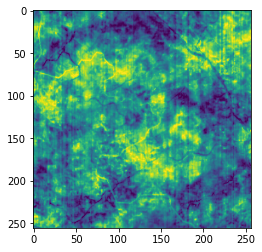

In [ ]:
plt.imshow(y_test[12].reshape(256,256))
y_test[12]

## *CONV2D*

In [ ]:
inp = layers.Input(shape=(4, *x_train.shape[2:]))
inp

<KerasTensor: shape=(None, 4, 192, 128, 1) dtype=float32 (created by layer 'input_2')>

In [ ]:
from tensorflow.keras.layers import Input
def fn_get_model_2D_timeD():

    t_frames, rows, cols = 4, 192, 128
    inp = layers.Input(shape=(4, *x_train.shape[2:]))
    #input_shape = (t_frames, rows, cols, 1)

    #inp = Input(shape=input_shape)
    inpN = BatchNormalization()(inp)

    c1 = Conv3D(filters=8, kernel_size= (5,5,5), strides=(1,1,1), activation='relu',
                kernel_initializer='glorot_uniform', padding='same')(inpN)
    c1 = BatchNormalization()(c1)
    # c1 = Conv3D(filters=8, kernel_size= (5,5,5), strides=(1,1,1), activation='relu',
    #             kernel_initializer='glorot_uniform', padding='same')(c1)
    # c1 = BatchNormalization()(c1)
    #pool_1 = MaxPooling3D(pool_size=(2,3,3))(c1)
    drop_1 = Dropout(0.25)(c1)

    c2 = Conv3D(filters=16, kernel_size= (3,3,3), strides=(1,1,1), activation='relu',
                kernel_initializer='glorot_uniform', padding='same')(drop_1)
    c2 = BatchNormalization()(c2)
    # c2 = Conv3D(filters=16, kernel_size= (3,3,3), strides=(1,1,1), activation='relu',
    #             kernel_initializer='glorot_uniform', padding='same')(c2)
    # c2 = BatchNormalization()(c2)
    # #pool_2 = MaxPooling3D(pool_size=(1,3,3))(c2)
    # drop_1 = Dropout(0.25)(c2)

    c3 = Conv3D(filters=32, kernel_size= (3,3,3), strides=(1,1,1), activation='relu',
                kernel_initializer='glorot_uniform', padding='same')(c2)
    c3 = BatchNormalization()(c3)
    # c3 = Conv3D(filters=32, kernel_size= (3,3,3), strides=(1,1,1), activation='relu',
    #             kernel_initializer='glorot_uniform', padding='same')(c3)
    # c3 = BatchNormalization()(c3)
    #pool_3 = MaxPooling3D(pool_size=(1,2,2))(c3)
    drop_3 = Dropout(0.15)(c3)

    flat = Flatten()(drop_3)
    hidden_1 = Dense(128, kernel_initializer='glorot_uniform', activation='relu')(flat)
    hidden_1 = BatchNormalization()(hidden_1)
    #hidden_1 = Dropout(0.3)(hidden_1)
    # hidden_2 = Dense(512, kernel_initializer='glorot_uniform', activation='relu')(hidden_1)
    # hidden_2 = BatchNormalization()(hidden_2)
    # hidden_2 = Dropout(0.3)(hidden_2)
    # hidden_3 = Dense(124, kernel_initializer='glorot_uniform', activation='relu')(hidden_2)
    # hidden_3 = BatchNormalization()(hidden_3)
    # hidden_3 = Dropout(0.3)(hidden_3)
    # hidden_4 = Dense(8, kernel_initializer='glorot_uniform', activation='relu')(hidden_3)
    # hidden_4 = BatchNormalization()(hidden_4)
    # hidden_4 = Dropout(0.3)(hidden_4)
    out = Dense(24576, activation='sigmoid')(hidden_1)

    model = Model(outputs=out, inputs=inp)
    model.compile(loss='mean_squared_error', optimizer='sgd',metrics=[tf.keras.metrics.mse])
    print(model.summary())
    return model


In [ ]:
model_cnn = fn_get_model_2D_timeD()

ResourceExhaustedError: OOM when allocating tensor with shape[3145728,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

In [ ]:
X = x_train
y = y_train.reshape(1895,24576)
X = X[:5]
y = y[:5]
X_val = x_test
y_val = y_test.reshape(56,24576)
print(X.shape,y.shape, X_val.shape, y_val.shape)

(5, 4, 192, 128, 1) (5, 24576) (56, 4, 192, 128, 1) (56, 24576)


In [ ]:
x_test[0].shape

(4, 192, 128, 1)

In [ ]:
from tensorflow.keras.callbacks import History
#history = History()
history = model_cnn.fit(X, y, batch_size=4, epochs=10, validation_data=(X_val, y_val))

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import History
from tensorflow import keras
import tensorflow_addons as tfa
model= load_model("F:\Jyoti Shukla -MS\codes\conv2d\conv2D_model_2.h5")
history=np.load('F:\Jyoti Shukla -MS\codes\conv2d\conv2D_model_2_history.npy',allow_pickle='TRUE').item()

c:\Users\user\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning:

Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons



OSError: Unable to open file (truncated file: eof = 1279787008, sblock->base_addr = 0, stored_eof = 1712046944)

In [ ]:
predicted = np.load("F:\Jyoti Shukla -MS\codes\conv2d\predicted_conv2d_model_2.npy")
predicted.shape

(56, 192, 128)

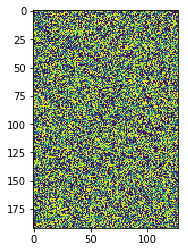

In [ ]:
plt.imshow(predicted[40])

In [ ]:
history = np.load("F:\Jyoti Shukla -MS\codes\conv2d\conv2D_model_2_history.npy",allow_pickle='True').item()
history.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error', 'lr'])

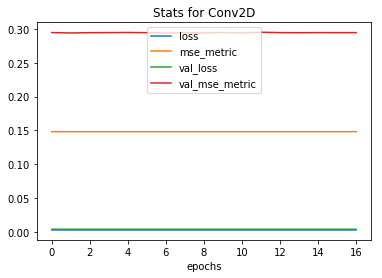

In [ ]:
plt.plot(history['loss'])
plt.plot(history['mean_squared_error'])
plt.plot(history['val_loss'])
plt.plot(history['val_mean_squared_error'])

plt.title('Stats for Conv2D')
plt.xlabel('epochs')
plt.legend(['loss','mse_metric','val_loss','val_mse_metric'])
plt.show()

In [ ]:
a1 = tf.constant([[1,2,1],[4,5,6]])
a1

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 2, 1],
       [4, 5, 6]])>

# Ensemble Method

In [ ]:
# scaled data loading
paired_train = np.load("F:\Jyoti Shukla -MS\karnataka dataset\paired_padded_arrays_train_total_AVHRR_data.npz")
train_image, train_label = paired_train['x'],paired_train['y']
paired_test = np.load("F:\Jyoti Shukla -MS\karnataka dataset\paired_padded_arrays_test_total_AVHRR_data.npz")
test_image, test_label = paired_test['x'],paired_test['y']
train_image.shape,test_image.shape

((2069, 192, 128, 1), (52, 192, 128, 1))

In [ ]:
predicted_convlstm_3d = np.load("F:\Jyoti Shukla -MS\codes\Saved models and history AVHRR_total/Predicted_outputs_ConvLSTM+Conv3D_total_model_6.1.npy")
predicted_convlstm_3d.shape

(48, 192, 128)

In [ ]:
predicted_LR = np.load("F:\Jyoti Shukla -MS\codes\Different model output total\Predicted_outputs_LR_total.npy")
predicted_LR.shape

(52, 192, 128)

In [ ]:
predicted_LR_sub = predicted_LR[:-4]
predicted_LR_sub.shape

(48, 192, 128)

In [ ]:
ensemble_LR_convlstm_total = (predicted_LR_sub + predicted_convlstm_3d)/2
ensemble_LR_convlstm_total.shape

(48, 192, 128)

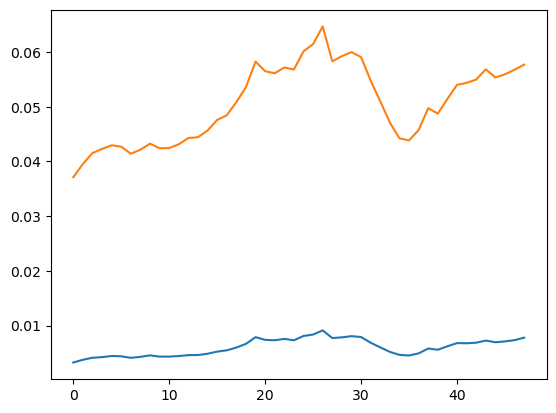

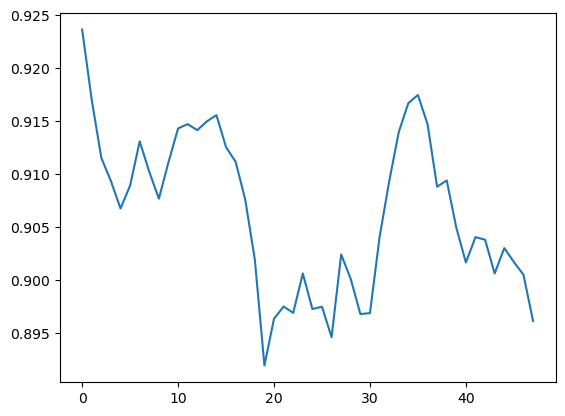

In [ ]:
MSE_ConvLSTM_LR =[]
R2_ConvLSTM_LR = []
MAE_ConvLSTM_LR =[]
preds = []
for i in range(len(test_image)-4):
    pred = ensemble_LR_convlstm_total[i].reshape(192,128)
    yreal = test_label[i].reshape(192,128)
    #r2 = r2_score(yreal,pred)
    err = mse(yreal,pred)
    r2 = r2_score(yreal,pred)
    abs_err = mae(yreal,pred)
    preds.append(pred)
    #R2.append(r2)
    MSE_ConvLSTM_LR.append(err)
    R2_ConvLSTM_LR.append(r2)
    MAE_ConvLSTM_LR.append(abs_err)
# print(MSE_ConvLSTM_LR)
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/R2_score_ConvLSTM_LR_total.npy", R2_ConvLSTM_LR)
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/MSE_score_ConvLSTM_LR_total.npy", MSE_ConvLSTM_LR)
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/MAE_score_ConvLSTM_LR_total.npy", MAE_ConvLSTM_LR)
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/predicted_ConvLSTM_LR_total.npy", preds)
#np.save("MSE_for_ConvLSTM_LR.npy", MSE_ConvLSTM_LR)
plt.plot(MSE_ConvLSTM_LR)
plt.plot(MAE_ConvLSTM_LR)
plt.show()
plt.plot(R2_ConvLSTM_LR)

In [ ]:
np.mean(R2_ConvLSTM_LR), np.max(R2_ConvLSTM_LR),np.mean(MSE_ConvLSTM_LR), np.mean(MAE_ConvLSTM_LR)

(0.9063624526139445, 0.9236537139069236, 0.0060031284, 0.05055405)

In [ ]:
predicted_pix2pix_total = np.load("F:\Jyoti Shukla -MS\codes\GAN models and outputs\model_10000_predicted_pix2pix_total.npy")
predicted_pix2pix_sub = predicted_pix2pix_total[:-4].reshape(48,192,128)
predicted_pix2pix_sub.shape

(48, 192, 128)

In [ ]:
ensemble_pix2pix_convlstm_total = (predicted_pix2pix_sub + predicted_convlstm_3d)/2
ensemble_pix2pix_convlstm_total.shape

(48, 192, 128)

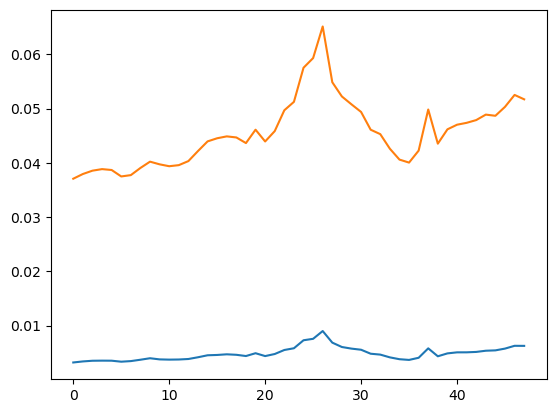

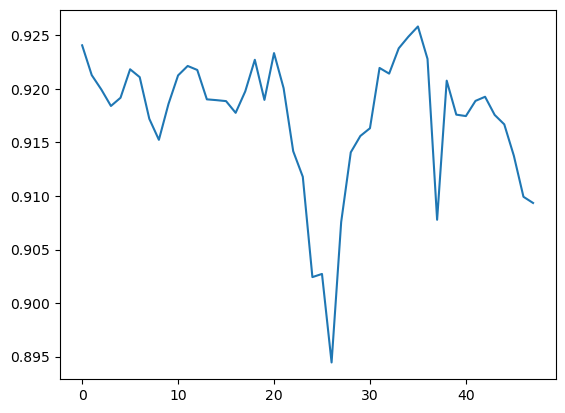

In [ ]:
MSE_ConvLSTM_pix2pix=[]
R2_ConvLSTM_pix2pix= []
MAE_ConvLSTM_pix2pix=[]
preds = []
for i in range(len(test_image)-4):
    pred = ensemble_pix2pix_convlstm_total[i].reshape(192,128)
    yreal = test_label[i].reshape(192,128)
    #r2 = r2_score(yreal,pred)
    err = mse(yreal,pred)
    r2 = r2_score(yreal,pred)
    abs_err = mae(yreal,pred)
    preds.append(pred)
    #R2.append(r2)
    MSE_ConvLSTM_pix2pix.append(err)
    R2_ConvLSTM_pix2pix.append(r2)
    MAE_ConvLSTM_pix2pix.append(abs_err)
# print(MSE_ConvLSTM_pix2pix)
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/R2_score_ConvLSTM_pix2pix_total.npy", R2_ConvLSTM_pix2pix)
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/MSE_score_ConvLSTM_pix2pix_total.npy", MSE_ConvLSTM_pix2pix)
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/MAE_score_ConvLSTM_pix2pix_total.npy", MAE_ConvLSTM_pix2pix)
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/predicted_ConvLSTM_pix2pix_total.npy", preds)
#np.save("MSE_for_ConvLSTM_pix2pix.npy", MSE_ConvLSTM_pix2pix)
plt.plot(MSE_ConvLSTM_pix2pix)
plt.plot(MAE_ConvLSTM_pix2pix)
plt.show()
plt.plot(R2_ConvLSTM_pix2pix)

In [ ]:
np.mean(R2_ConvLSTM_pix2pix), np.max(R2_ConvLSTM_pix2pix),np.mean(MSE_ConvLSTM_pix2pix), np.mean(MAE_ConvLSTM_pix2pix)

(0.9173016886626876, 0.925835258620577, 0.0048298636, 0.045526933)

In [ ]:
predicted_DT_total = np.load("F:\Jyoti Shukla -MS\codes\Different model output total\Predicted_outputs_DT_total.npy")
predicted_DT_sub = predicted_DT_total[:-4].reshape(48,192,128)
predicted_DT_sub.shape

(48, 192, 128)

In [ ]:
ensemble_DT_convlstm_total = (predicted_DT_sub + predicted_convlstm_3d)/2
ensemble_DT_convlstm_total.shape

(48, 192, 128)

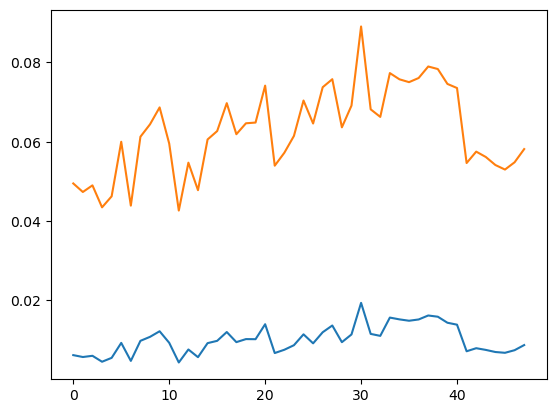

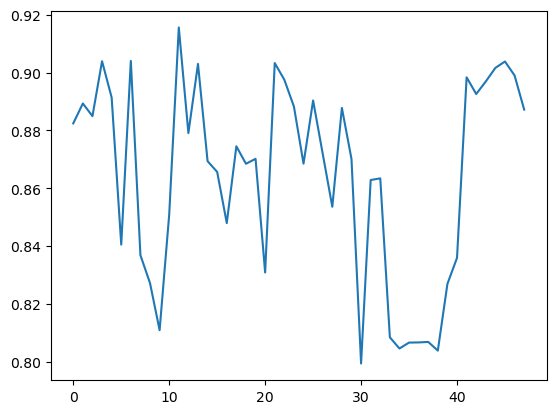

In [ ]:
MSE_ConvLSTM_DT=[]
R2_ConvLSTM_DT= []
MAE_ConvLSTM_DT=[]
preds = []
for i in range(len(test_image)-4):
    pred = ensemble_DT_convlstm_total[i].reshape(192,128)
    yreal = test_label[i].reshape(192,128)
    #r2 = r2_score(yreal,pred)
    err = mse(yreal,pred)
    r2 = r2_score(yreal,pred)
    abs_err = mae(yreal,pred)
    preds.append(pred)
    #R2.append(r2)
    MSE_ConvLSTM_DT.append(err)
    R2_ConvLSTM_DT.append(r2)
    MAE_ConvLSTM_DT.append(abs_err)
# print(MSE_ConvLSTM_DT)
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/R2_score_ConvLSTM_DT_total.npy", R2_ConvLSTM_DT)
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/MSE_score_ConvLSTM_DT_total.npy", MSE_ConvLSTM_DT)
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/MAE_score_ConvLSTM_DT_total.npy", MAE_ConvLSTM_DT)
np.save("F:\Jyoti Shukla -MS\codes\Different model output total/predicted_ConvLSTM_DT_total.npy", preds)
#np.save("MSE_for_ConvLSTM_DT.npy", MSE_ConvLSTM_DT)
plt.plot(MSE_ConvLSTM_DT)
plt.plot(MAE_ConvLSTM_DT)
plt.show()
plt.plot(R2_ConvLSTM_DT)

In [ ]:
np.mean(R2_ConvLSTM_DT), np.max(R2_ConvLSTM_DT),np.mean(MSE_ConvLSTM_DT), np.mean(MAE_ConvLSTM_DT)

(0.8642703164906109,
 0.9155961044304997,
 0.010071369919465572,
 0.06267245565505643)